#### Custom Notebook for the validation of predictions from Electron Microscopy data analysis. Imports segmented 3D EM data and ground truth, and outputs the following:

- Correlations between predicted and validation (ground gruth) data, for:
    - Area
    - Eccentricity
    - major axis length
    - minor axis length
    - g Ratio
    - Percentage of False Positives / Negatives

To be included in the future:
- Dice coefficient
- Bland-Altman plot

In [2]:
# import dependencies
import numpy as np
import tifffile as tf
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import pandas as pd
import math as m
import skimage
import cv2
import scipy
from skimage.measure import regionprops, regionprops_table
from skimage.morphology import disk
import colorcet as cc
%matplotlib inline


In [3]:
def resolve_undersegmentation(outer_labels,inner_labels):
    '''
    resolves undersegmented cells with 'kissing' cells. This function assumes that inner_labels never touch, but outer_labels do.
    Each corresponding outer area must touch each corresponding inner area.

    outer_labels = outer labels with undersegmented kissing cells that need to be seperated
    inner_labels = inner labels without undersegmented kissing cells

    returns: Two arrays of the same shape, with uniform labels across both images. 
    '''
    from skimage.segmentation import watershed
    from skimage.feature import peak_local_max
    outer_labels = outer_labels.astype('bool')
    inner_labels = inner_labels.astype('bool')
    # do distance transformation of combined binary image of outer+inner
    seg_dist = ndi.distance_transform_edt(outer_labels+inner_labels)
    # Generate the markers as local maxima of the distance to the background
    coords = peak_local_max(seg_dist, footprint=np.ones((3, 3)), labels=ndi.label(inner_labels)[0], num_peaks_per_label=1)
    # initializie empty mask 
    mask = np.zeros(seg_dist.shape, dtype=bool)
    # insert maximum points into the empty array
    mask[tuple(coords.T)] = True
    # label each maximum
    markers, n = ndi.label(mask)
    # print("number of cells: " + str(n))
    # perform watershed on outer_labels and inner_labels combined
    outer_cells = watershed(-seg_dist, markers, mask=(outer_labels+inner_labels))
    inner_cells = np.copy(outer_cells)
    # sort the cells (which are now labeled with the same label inner and outer) back into inner and outer labels
    inner_cells[inner_labels==0] = 0
    outer_cells[inner_labels==True] = 0
    return outer_cells,inner_cells

def keep_largest_structure(boolean_array):
    from scipy import ndimage
    # Label each connected component in the boolean array
    labeled_array, num_features = ndimage.label(boolean_array)

    # Calculate the size of each labeled component
    component_sizes = np.bincount(labeled_array.ravel())

    # Find the index of the largest component
    largest_component_index = np.argmax(component_sizes[1:]) + 1

    # Create a boolean mask to keep only the largest component
    largest_component_mask = labeled_array == largest_component_index

    # Apply the mask to the boolean array
    boolean_array[largest_component_mask] = True
    boolean_array[~largest_component_mask] = False

    return boolean_array

# define qualitative colormap
glasbey = cc.cm.glasbey_dark_r
glasbey.set_under(color="black")

In [4]:
open_path = (
            r"G:\AG_Morawski\Philip\EM\Uni-EM\test_output_val\36_raw_predicted.png",#prediction
            r"G:\AG_Morawski\Philip\EM\Uni-EM\test_output_ctrl_val\36_labels.png",#ground truth
            )

save_path = r"G:/AG_Morawski/Philip/EM/Uni-EM/test_img_output_val/"

crop = False

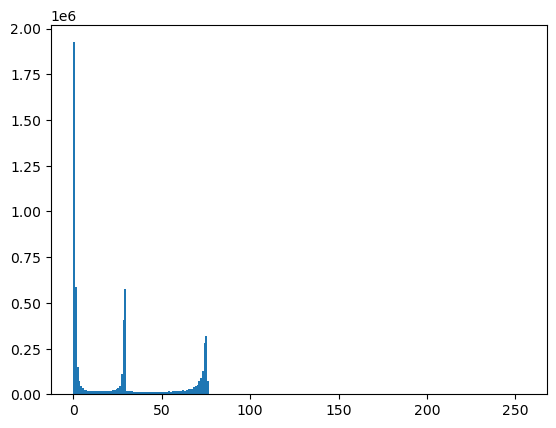

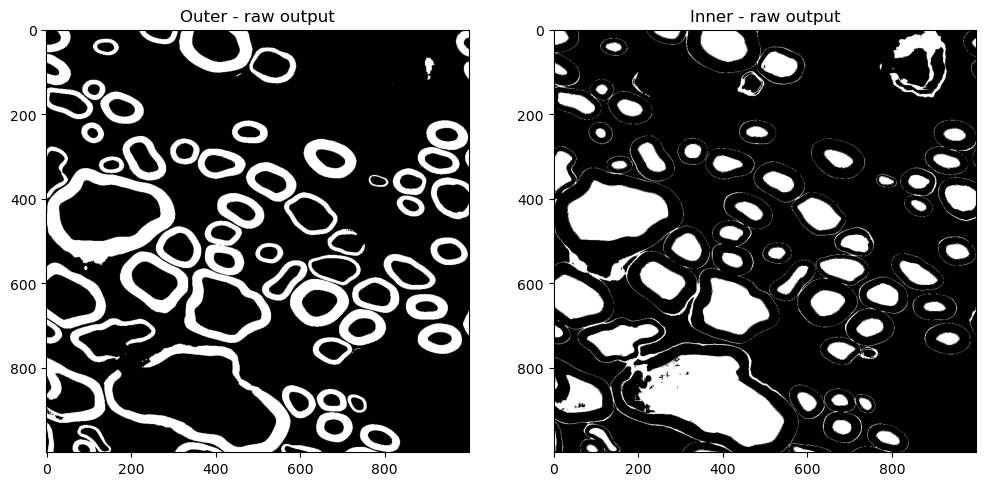

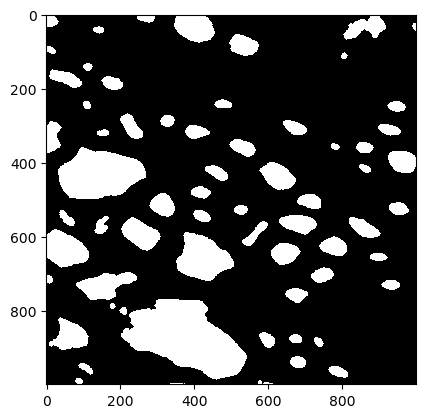

In [5]:
# open data
img = cv2.imread(open_path[0])
img_val = cv2.imread(open_path[1])
val_inner = img_val[:,:,2]
val_outer = img_val[:,:,0]

# lose two dimensions, since its a grayscale img 
img = img[:,:,0]

plt.hist(img.ravel(), bins=256, range=(0, 255),)
plt.show()

# split different labels
pred_outer = np.zeros_like(img)
pred_inner = np.zeros_like(img)
pred_outer[img>50] = 1
pred_inner[img<40] = 1
pred_inner[img<24] = 0

fig, axs = plt.subplots(ncols=2,figsize=(12,12))
axs[0].imshow(pred_outer[0:1000,0:1000], cmap='gray')
axs[1].imshow(pred_inner[0:1000,0:1000], cmap='gray')
axs[0].set_title('Outer - raw output')
axs[1].set_title('Inner - raw output')
plt.show()

# binary opening to get rid of small speckles
# pred_inner = ndi.binary_opening(pred_inner,structure=disk(2))
pred_inner = ndi.binary_opening(pred_inner,structure=disk(5))

# fill holes
pred_inner = ndi.binary_fill_holes(pred_inner)

# binary opening to get rid of small speckles
# pred_inner = ndi.binary_opening(pred_inner,structure=disk(6))
pred_inner = ndi.binary_opening(pred_inner,structure=disk(7))

plt.imshow(pred_inner[0:1000,0:1000],interpolation='None',cmap='gray')
plt.show()

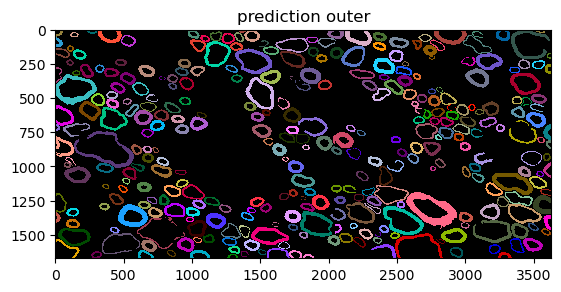

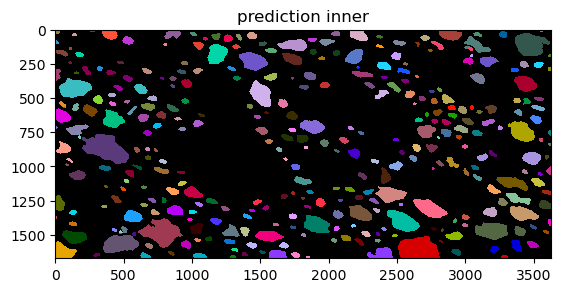

403


In [6]:
#crop
if crop == True:
    crop_value = 2000
    pred_inner = pred_inner[0:crop_value,0:crop_value]
    pred_outer = pred_outer[0:crop_value,0:crop_value]
    val_inner = val_inner[0:crop_value,0:crop_value]
    val_outer = val_outer[0:crop_value,0:crop_value]

# fill inner to outer label to make sure they touch
pred_inner = ndi.binary_dilation(pred_inner,structure=disk(5))
pred_inner[pred_outer==True]=0

#re-label so the labels are uniform between both channels.
pred_outer_labeled,pred_inner_labeled = resolve_undersegmentation(pred_outer.astype('bool'),pred_inner.astype('bool'))
plt.title('prediction outer')
plt.imshow(pred_outer_labeled,cmap=glasbey,interpolation='None',vmin=0.1,vmax=pred_outer_labeled.max())
plt.show()
plt.title('prediction inner')
plt.imshow(pred_inner_labeled,cmap=glasbey,interpolation='None',vmin=0.1,vmax=pred_outer_labeled.max())
plt.show()

n_pred_cells_raw = np.max(pred_inner_labeled)
print(n_pred_cells_raw)

In [7]:
print(len(np.unique(pred_outer_labeled)))
print(len(np.unique(pred_inner_labeled)))
print(np.unique(pred_outer_labeled))
print(np.unique(pred_inner_labeled))

333
404
[  0   1   2   3   4   5   6   7   8  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  29  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  52  65  67  68  69  70  71  72
  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  96  97  98  99 100 101 102 103 104 105 106 107 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 140 141 142 143 145 146 149 151 153 155 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 180 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 220 221 226 229
 231 232 233 234 235 237 238 239 240 241 242 243 244 246 247 249 250 255
 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273
 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291
 292 293 294 295 296 297 298 299 300 301 30

In [8]:
n_labeled_without_outer = 0
n_labeled_without_inner = 0

# iterate through np.unique(pred_inner_labeled), delete all cells that do not have axon or myelin.
for id in np.unique(pred_inner_labeled):
    # check if id is in pred_outer_labeled
    if id not in pred_outer_labeled:
        # if not, delete in pred_inner_labeled
        pred_inner_labeled[pred_inner_labeled==id] = 0
        print("deleted inner label #" + str(id))
        n_labeled_without_outer += 1

for id in np.unique(pred_outer_labeled):
    if id not in pred_inner_labeled:
        # if not, delete in pred_outer_labeled
        pred_outer_labeled[pred_outer_labeled==id] = 0
        print("deleted outer label #" + str(id))
        n_labeled_without_inner += 1

deleted inner label #9
deleted inner label #27
deleted inner label #28
deleted inner label #30
deleted inner label #31
deleted inner label #51
deleted inner label #53
deleted inner label #54
deleted inner label #55
deleted inner label #56
deleted inner label #57
deleted inner label #58
deleted inner label #59
deleted inner label #60
deleted inner label #61
deleted inner label #62
deleted inner label #63
deleted inner label #64
deleted inner label #66
deleted inner label #78
deleted inner label #93
deleted inner label #94
deleted inner label #95
deleted inner label #108
deleted inner label #109


deleted inner label #137
deleted inner label #138
deleted inner label #139
deleted inner label #144
deleted inner label #147
deleted inner label #148
deleted inner label #150
deleted inner label #152
deleted inner label #154
deleted inner label #156
deleted inner label #157
deleted inner label #158
deleted inner label #159
deleted inner label #178
deleted inner label #179
deleted inner label #202
deleted inner label #217
deleted inner label #218
deleted inner label #219
deleted inner label #222
deleted inner label #223
deleted inner label #224
deleted inner label #225
deleted inner label #227
deleted inner label #228
deleted inner label #230
deleted inner label #236
deleted inner label #245
deleted inner label #248
deleted inner label #251
deleted inner label #252
deleted inner label #253
deleted inner label #254
deleted inner label #330
deleted inner label #333
deleted inner label #335
deleted inner label #336
deleted inner label #337
deleted inner label #339
deleted inner label #340


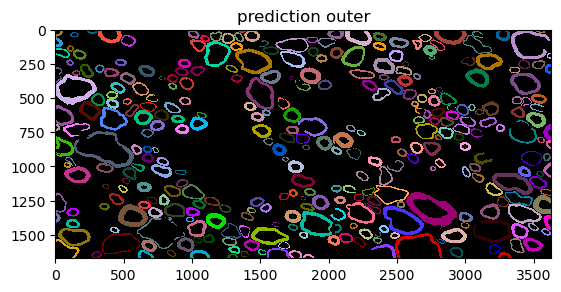

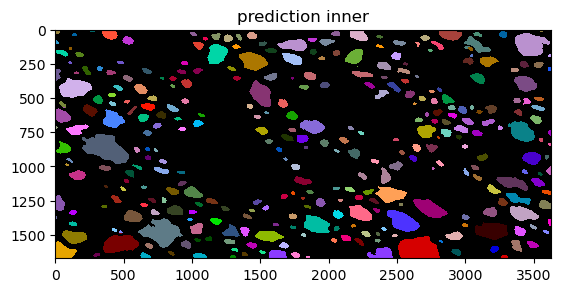

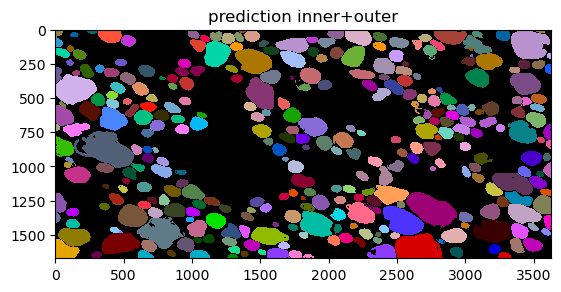

385


In [9]:
pred_outer_labeled,pred_inner_labeled = resolve_undersegmentation(pred_outer_labeled.astype('bool'),pred_inner_labeled.astype('bool'))
plt.title('prediction outer')
plt.imshow(pred_outer_labeled,cmap=glasbey,interpolation='None',vmin=0.1)
plt.savefig(save_path + "\pre_prediction_outer.png",dpi=500)
plt.show()
plt.title('prediction inner')
plt.imshow(pred_inner_labeled,cmap=glasbey,interpolation='None',vmin=0.1)
plt.savefig(save_path + "\pre_prediction_inner.png",dpi=500)
plt.show()
plt.title('prediction inner+outer')
plt.imshow(pred_inner_labeled+pred_outer_labeled,cmap=glasbey,interpolation='None',vmin=0.1)
plt.savefig(save_path + "\pre_prediction_inner_outer.png",dpi=500)
plt.show()

n_pred_cells_corrected = np.max(pred_inner_labeled)
print(n_pred_cells_corrected)

In [10]:
print(len(np.unique(pred_outer_labeled)))
print(len(np.unique(pred_inner_labeled)))
print(np.unique(pred_outer_labeled))
print(np.unique(pred_inner_labeled))

333
386


[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  29  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  51  60  61  62  63  64  65  66
  67  68  69  70  71  76  77  79  80  81  82  83  84  85  86  87  88  89
  90  95  96  97  98  99 100 101 102 103 104 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 136 137 138 139 140 141 143 144 146 150 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169 170 171 173 174 175 176
 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194
 195 196 197 198 199 200 201 202 203 204 205 206 207 208 212 213 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 236
 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254
 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272
 273 274 275 276 277 278 279 280 281 282 283 284 28

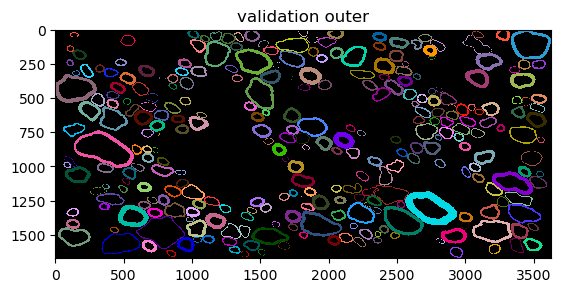

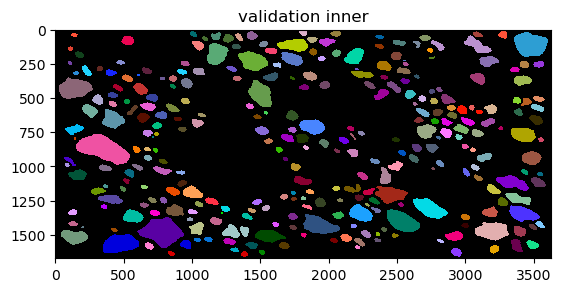

In [11]:
# fill inner to outer label to make sure they touch
# this is needed to ensure good watershed performance later
val_inner = ndi.binary_dilation(val_inner,structure=disk(5))
val_inner[val_outer==True]=0

#re-label so the labels are uniform between both channels.
val_outer_labeled,val_inner_labeled = resolve_undersegmentation(val_outer.astype('bool'),val_inner.astype('bool'))

plt.title('validation outer')
plt.imshow(val_outer_labeled,cmap=glasbey,interpolation='None',vmin=0.1)
plt.show()
plt.title('validation inner')
plt.imshow(val_inner_labeled,cmap=glasbey,interpolation='None',vmin=0.1)
plt.show()

In [12]:
pred_both_labeled = pred_inner_labeled+pred_outer_labeled
val_both_labeled = val_inner_labeled+val_outer_labeled

# plt.imshow(ndi.binary_dilation(pred_both_labeled[20:100,3250:3500,]))


In [13]:
# np.count_nonzero(pred_both_labeled[20:60,3250:3290,])
# pred_both_labeled[20,3250]

#### Cleanup of predicted data
Remove segmented cells that touch the border of the image.

In [14]:
n_cells_removed_border_pred = 0

# remove cells that intersect with the border
border_mask = np.zeros(pred_both_labeled.shape, dtype=bool)
border_mask = ndi.binary_dilation(border_mask,iterations=5, border_value=5)

for id in np.unique(pred_both_labeled):
    if id == 0:
        continue
    #keep only current cell as temporary mask
    current_id_mask = pred_both_labeled==id 

    # check if it overlaps with the border mask
    overlap = np.logical_and(border_mask,current_id_mask)
    overlap_n = np.sum(overlap)
    
    if overlap_n > 0:
        pred_both_labeled[pred_both_labeled==id] = 0
        print("deleted cell #" + str(id))
        n_cells_removed_border_pred += 1


deleted cell #1
deleted cell #2
deleted cell #3
deleted cell #4
deleted cell #5
deleted cell #6
deleted cell #7
deleted cell #8
deleted cell #9
deleted cell #11
deleted cell #13


deleted cell #25
deleted cell #32
deleted cell #44
deleted cell #47
deleted cell #79
deleted cell #88
deleted cell #115
deleted cell #165
deleted cell #180
deleted cell #190
deleted cell #204
deleted cell #213
deleted cell #224
deleted cell #242
deleted cell #268
deleted cell #284
deleted cell #287
deleted cell #308
deleted cell #314
deleted cell #334
deleted cell #372
deleted cell #375
deleted cell #376
deleted cell #377
deleted cell #378
deleted cell #379
deleted cell #380
deleted cell #381
deleted cell #382
deleted cell #383
deleted cell #384
deleted cell #385


In [15]:
n_cells_removed_border_val = 0

# remove cells that intersect with the border
border_mask = np.zeros(val_inner_labeled.shape, dtype=bool)
border_mask = ndi.binary_dilation(border_mask,iterations=5, border_value=5)

for id in np.unique(val_inner_labeled):
    if id == 0:
        continue
    #keep only current cell as temporary mask
    current_id_mask = val_both_labeled==id 

    # check if it overlaps with the border mask
    overlap = np.logical_and(border_mask,current_id_mask)
    overlap_n = np.sum(overlap)

    if overlap_n > 0:
        val_both_labeled[val_both_labeled==id] = 0
        print("deleted cell #" + str(id))
        n_cells_removed_border_val += 1


deleted cell #1
deleted cell #2
deleted cell #3
deleted cell #5
deleted cell #7
deleted cell #20


deleted cell #81
deleted cell #301


In [16]:
# re-label structures so all cells have continous numbering.
# So far, labels are arbitrary and label numbrers do not correspond to the same cell in different images.
# pred_both_labeled[pred_both_labeled>0] = 1
# pred_both_labeled, n_struct = ndi.label(pred_both_labeled)
# val_both_labeled, n_struct_val = ndi.label(val_both_labeled)

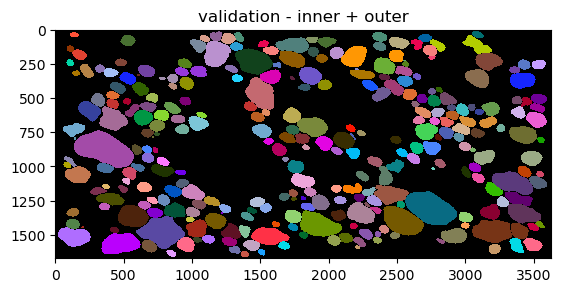

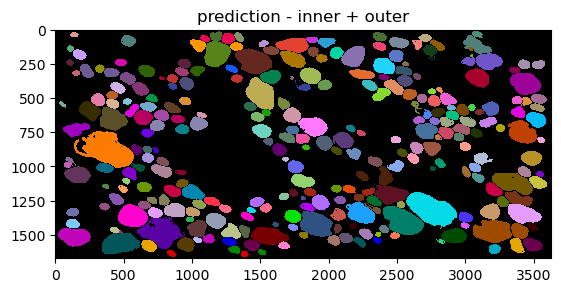

In [17]:
# "mislabeled" data. not congruent IDs for now
plt.title('validation - inner + outer')
plt.imshow(val_both_labeled,cmap=glasbey,interpolation='None',vmin=0.1,vmax=np.max(pred_both_labeled))
plt.show()
plt.title('prediction - inner + outer')
plt.imshow(pred_both_labeled,cmap=glasbey,interpolation='None',vmin=0.1,vmax=np.max(pred_both_labeled))
plt.show()

In [18]:
n_false_positive = 0
n_false_negative = 0

# Here, we start to define which cell (in predicted data) belongs to which other cell (in validation data). 
# Start by extracting centroids from the validation and prediction data.
# centroids_val = regionprops_table(label_image=val_inner_labeled,properties=('centroid',))
centroids_val = regionprops_table(label_image=val_both_labeled,properties=('centroid',))
centroids_val_x = centroids_val['centroid-0']
centroids_val_y = centroids_val['centroid-1']

# centroids_pred = regionprops_table(label_image=pred_inner_labeled,properties=('centroid',))
centroids_pred = regionprops_table(label_image=pred_both_labeled,properties=('centroid',))
centroids_pred_x = centroids_pred['centroid-0']
centroids_pred_y = centroids_pred['centroid-1']

# stack arrays to 2-dimensional arrays
val_points = np.column_stack((centroids_val_x, centroids_val_y))
pred_points = np.column_stack((centroids_pred_x, centroids_pred_y))

# initialize boolean array which has True values where centroids are for both sets of cells
val_bool_array = np.zeros_like(pred_both_labeled, dtype=bool)
for yx in val_points:
    val_bool_array[round(yx[0]),round(yx[1])]=True

pred_bool_array = np.zeros_like(pred_both_labeled, dtype=bool)
for yx in pred_points:
    pred_bool_array[round(yx[0]),round(yx[1])]=True

# label centroid bool arrays by iterating through them
bool_array_val_labeled,n = ndi.label(val_bool_array)
bool_array_pred_labeled,n_pred = ndi.label(pred_bool_array)

# iterate through validation cells, delete ones that do not have a matching predicted cell
for id in np.unique(bool_array_val_labeled):
    if id == 0:
        continue
    y,x = np.argwhere(bool_array_val_labeled==id)[0]
    # if this statement is true, the cell has not been found. 
    # therefore, we exclude it from further validation and flood fill it with 0's in validation data.
    if pred_both_labeled[y,x] == 0:
        val_both_labeled = skimage.segmentation.flood_fill(val_both_labeled,
                                                          (y,x),
                                                          new_value=0,
                                                          )
        print('deleted cell in validation data (found a false negative): ' + str(id))
        n_false_negative += 1

# iterate through predicted cells, delete ones that do not have a matching predicted cell
for id in np.unique(bool_array_pred_labeled):
    if id == 0:
        continue
    y,x = np.argwhere(bool_array_pred_labeled==id)[0]
    
    if val_both_labeled[y,x]==0:# if there is no cell to test against, delete cell
        pred_both_labeled = skimage.segmentation.flood_fill(image=pred_both_labeled,
                                                       seed_point=(y,x),
                                                       new_value=0,
                                                       )
        print('deleted cell in prediction data (found a false positive): ' + str(id))
        n_false_positive +=1


deleted cell in validation data (found a false negative): 30
deleted cell in validation data (found a false negative): 33
deleted cell in validation data (found a false negative): 42
deleted cell in validation data (found a false negative): 56
deleted cell in validation data (found a false negative): 106
deleted cell in validation data (found a false negative): 139
deleted cell in validation data (found a false negative): 141
deleted cell in validation data (found a false negative): 142
deleted cell in validation data (found a false negative): 146
deleted cell in validation data (found a false negative): 161
deleted cell in validation data (found a false negative): 203
deleted cell in validation data (found a false negative): 213
deleted cell in validation data (found a false negative): 226
deleted cell in validation data (found a false negative): 240
deleted cell in validation data (found a false negative): 253
deleted cell in validation data (found a false negative): 259
deleted cell

In [19]:
# val_both_labeled_temp, n = ndi.label(val_both_labeled)
# pred_both_labeled_temp, n2 = ndi.label(pred_both_labeled)
# # at this point, both arrays should have the same number of cells:
# print('cells in validation data: ' + str(n))
# print('cells in predicted data: ' + str(n2))

In [20]:
# Now, we need to label each specific cell with the same label in prediction and validation arrays.
# To do that, we iterate through the prediction array and label the validation cells with the same number.
# We do this by flood filling from each centroid.
for id in np.unique(bool_array_val_labeled):
    if id == 0:
        continue
    y,x = np.argwhere(bool_array_val_labeled==id)[0]

    # if there is no cell at the point want to fill it in, delete cell altogether
    if pred_both_labeled[y,x]==0: # if this is true: delete cell
        val_both_labeled = skimage.segmentation.flood_fill(image=val_both_labeled,
                                                           seed_point=(y,x),
                                                           new_value=0,
                                                          )
        print("cell deleted: " + str(id))
        n_false_negative += 1
        continue

    # if there is a cell, fill it in with the same label as in mask_val_labeled
    pred_both_labeled = skimage.segmentation.flood_fill(image=pred_both_labeled,
                                                   seed_point=(y,x),
                                                   new_value=id,
                                                   )
    
    # if there is a cell, fill it in with the same label as in mask_val_labeled
    val_both_labeled = skimage.segmentation.flood_fill(image=val_both_labeled,
                                                   seed_point=(y,x),
                                                   new_value=id,
                                                   )



cell deleted: 30
cell deleted: 33
cell deleted: 42
cell deleted: 56
cell deleted: 106
cell deleted: 139
cell deleted: 141
cell deleted: 142
cell deleted: 146
cell deleted: 161
cell deleted: 203
cell deleted: 213
cell deleted: 226
cell deleted: 240
cell deleted: 253
cell deleted: 259
cell deleted: 290


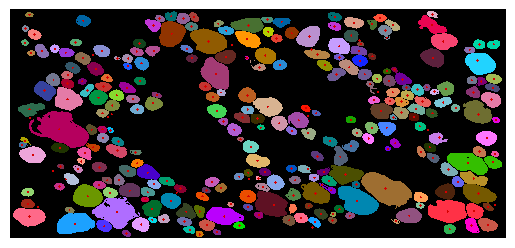

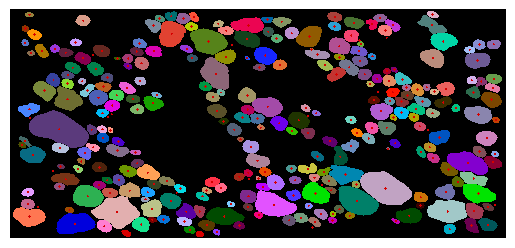

In [21]:
bool_array_labeled_dil = ndi.binary_dilation(bool_array_val_labeled,iterations=10)

plt.axis("off")
plt.imshow(pred_both_labeled,cmap=glasbey,interpolation='None',vmin=0.1)
plt.imshow(np.ma.array(bool_array_labeled_dil, mask=bool_array_labeled_dil==0), interpolation='none', cmap=glasbey,vmin=0.1)
plt.show()

plt.axis("off")
plt.imshow(val_both_labeled,cmap=glasbey,interpolation='None',vmin=0.1)
plt.imshow(np.ma.array(bool_array_labeled_dil, mask=bool_array_labeled_dil==0), interpolation='none', cmap=glasbey,vmin=0.1)
plt.show()

# plt.imshow(ndi.binary_dilation(bool_array_labeled,iterations=10))
# plt.show()

In [22]:
print(len(np.unique(val_both_labeled)))
print(len(np.unique(pred_both_labeled)))

279
295


In [23]:
#seperate inner and outer channels back from the combined pictures
pred_inner_labeled = np.copy(pred_both_labeled)
pred_inner_labeled[pred_inner==False]=0

pred_outer_labeled = np.copy(pred_both_labeled)
pred_outer_labeled[pred_outer==False]=0

val_inner_labeled = np.copy(val_both_labeled)
val_inner_labeled[val_inner==False] = 0

val_outer_labeled = np.copy(val_both_labeled)
val_outer_labeled[val_outer==False] = 0

In [24]:
print(len(np.unique(pred_outer_labeled)))
print(len(np.unique(pred_inner_labeled)))
print(len(np.unique(val_outer_labeled)))
print(len(np.unique(val_inner_labeled)))

281
295
278
279


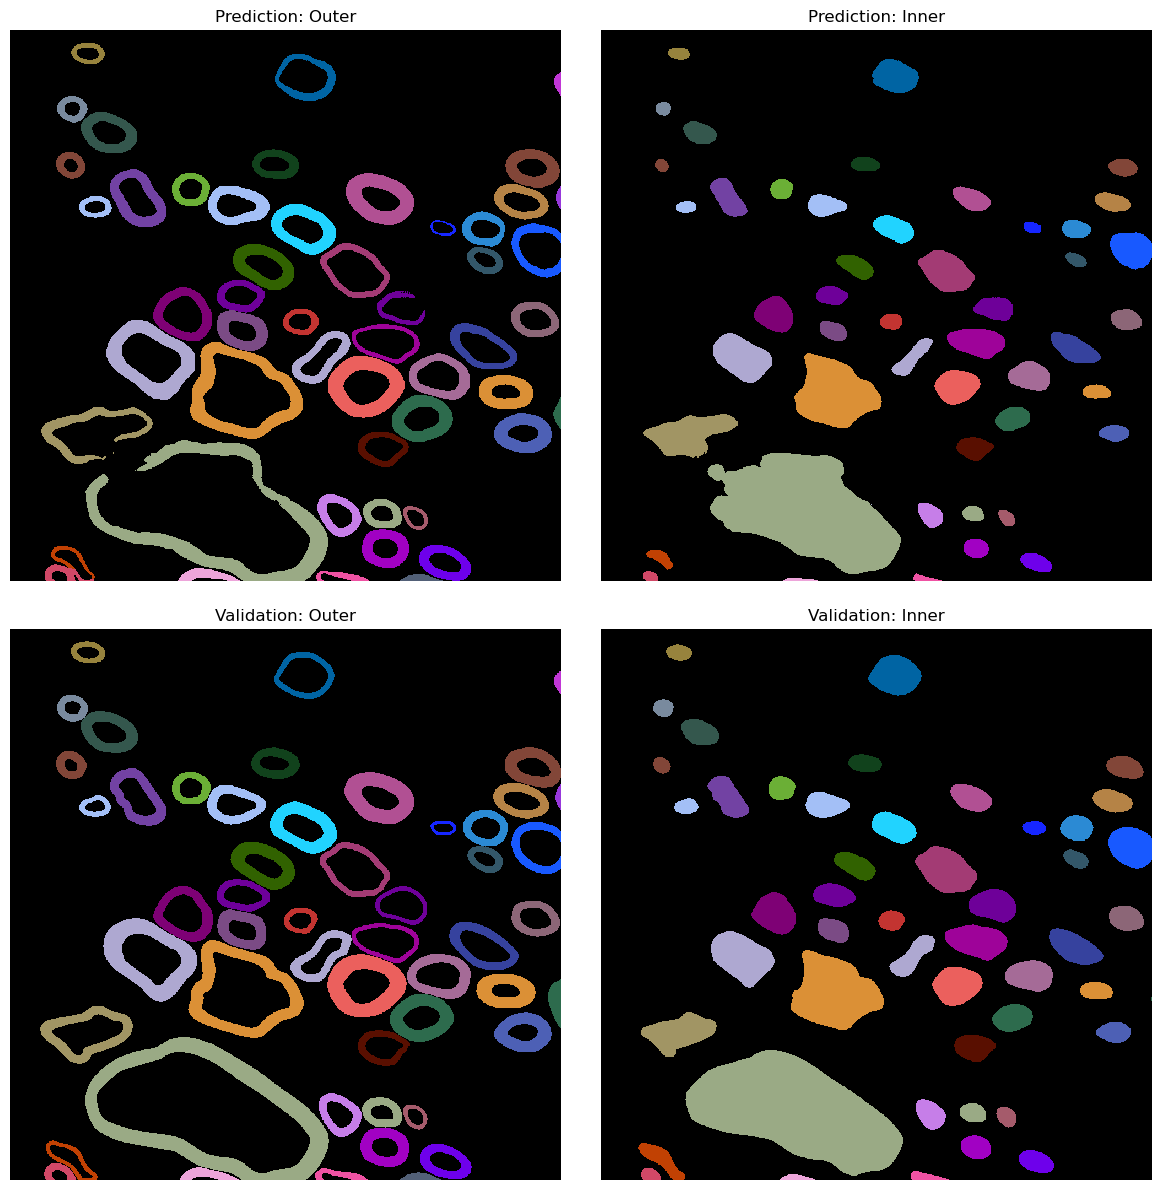

In [25]:
#plot all four channels in 2x2 grid
fig, axs = plt.subplots(ncols=2,nrows=2, figsize=(12,12))
axs[0,0].imshow(pred_outer_labeled[0:1000,0:1000], cmap=glasbey, interpolation='None',vmin=0.1,vmax=pred_outer_labeled.max())
axs[0,1].imshow(pred_inner_labeled[0:1000,0:1000], cmap=glasbey, interpolation='None',vmin=0.1,vmax=pred_outer_labeled.max())
axs[1,0].imshow(val_outer_labeled[0:1000,0:1000], cmap=glasbey, interpolation='None',vmin=0.1,vmax=pred_outer_labeled.max())
axs[1,1].imshow(val_inner_labeled[0:1000,0:1000], cmap=glasbey, interpolation='None',vmin=0.1,vmax=pred_outer_labeled.max())
# Remove axis for each subplot
axs[0, 0].axis('off')
axs[0, 1].axis('off')
axs[1, 0].axis('off')
axs[1, 1].axis('off')
axs[0,0].set_title('Prediction: Outer')
axs[0,1].set_title('Prediction: Inner')
axs[1,0].set_title('Validation: Outer')
axs[1,1].set_title('Validation: Inner')
plt.tight_layout(h_pad=2)
plt.savefig(save_path + "\predict_val_comparison.png",dpi=500)
plt.show()

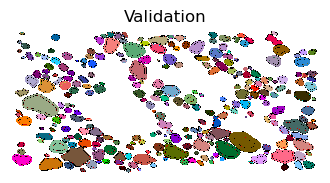

In [26]:
# plot overlay of inner + outer
# generate 2px outline of inner and outer area
val_outer_eroded = ndi.binary_erosion(val_outer_labeled,structure=disk(3))
ero = np.logical_xor(val_outer_labeled.astype('bool'),val_outer_eroded)

plt.figure(figsize=(4,12))
plt.title('Validation')
plt.imshow(np.ma.array(val_inner_labeled + val_outer_labeled, mask=(val_inner_labeled + val_outer_labeled) == 0), cmap=glasbey,interpolation='none',vmin=0.1,vmax=pred_outer_labeled.max())
plt.imshow(np.ma.array(ero, mask=(ero) == 0), interpolation='None', cmap='gray',)
plt.axis('off')
plt.savefig(save_path + "val_labeled_cells_outlined.png",dpi=500)
plt.show()

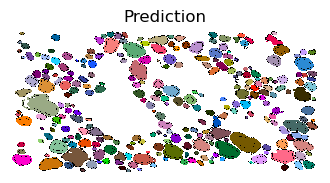

In [27]:
# plot overlay of inner + outer
# generate 2px outline of inner and outer area
pred_outer_eroded = ndi.binary_erosion(pred_outer_labeled,structure=disk(3))
ero = np.logical_xor(pred_outer_labeled.astype('bool'),pred_outer_eroded)

plt.figure(figsize=(4,12))
plt.title('Prediction')
plt.imshow(np.ma.array(pred_inner_labeled + pred_outer_labeled, mask=(pred_inner_labeled + pred_outer_labeled) == 0), cmap=glasbey,interpolation='none',vmin=0.1,vmax=pred_outer_labeled.max())
plt.imshow(np.ma.array(ero, mask=(ero) == 0), interpolation='None', cmap='gray',)
plt.axis('off')
plt.savefig(save_path + "pred_labeled_cells_outlined.png",dpi=500)
plt.show()

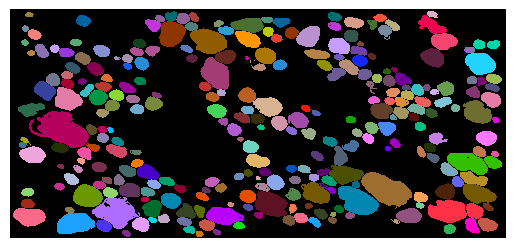

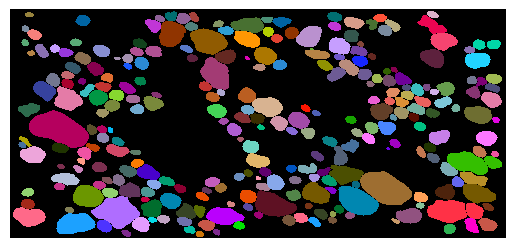

In [27]:
plt.axis("off")
plt.imshow(pred_both_labeled,cmap=glasbey,interpolation='None',vmin=0.1,vmax=np.max(pred_both_labeled))
# plt.imshow(np.ma.array(bool_array_val_labeled, mask=bool_array_val_labeled==0), interpolation='none', cmap='tab20')
plt.show()

plt.axis("off")
plt.imshow(val_both_labeled,cmap=glasbey,interpolation='None',vmin=0.1,vmax=np.max(pred_both_labeled))
# plt.imshow(np.ma.array(bool_array_val_labeled, mask=bool_array_val_labeled==0), interpolation='none', cmap='tab20')
plt.show()

In [28]:
### this code block is not final. need fo find a good solution for this problem.

# here, we hard filter every cell that does not have a corresponding val or pred cell. Mostly, these are single pixel cells

# iterate through np.unique(pred_outer_labeled), delete all cells that do not have corresponding inner or outer
# also delete every cell that does not have a corresponding val or pred cell
for id in np.unique(pred_outer_labeled):
    # check if id is in val_outer_labeled
    if id not in val_outer_labeled:
        # if not, delete in pred_outer_labeled
        pred_outer_labeled[pred_outer_labeled==id] = 0
        print("deleted outer prediction label #" + str(id))
        n_false_positive += 1

for id in np.unique(val_outer_labeled):
    if id not in pred_outer_labeled:
        # if not, delete in pred_outer_labeled
        val_outer_labeled[val_outer_labeled==id] = 0
        print("deleted outer validation label #" + str(id))
        n_false_negative += 1

for id in np.unique(pred_inner_labeled):
    if id not in val_inner_labeled:
        # if not, delete in pred_outer_labeled
        pred_inner_labeled[pred_inner_labeled==id] = 0
        print("deleted inner prediction label #" + str(id))
        n_false_positive += 1


for id in np.unique(val_inner_labeled):
    if id not in pred_inner_labeled:
        # if not, delete in pred_outer_labeled
        val_inner_labeled[val_inner_labeled==id] = 0
        print("deleted inner validation label #" + str(id))
        n_false_negative += 1


deleted outer prediction label #181
deleted outer prediction label #316
deleted outer prediction label #326
deleted outer prediction label #337
deleted outer validation label #46
deleted inner prediction label #30
deleted inner prediction label #142
deleted inner prediction label #310
deleted inner prediction label #311
deleted inner prediction label #312
deleted inner prediction label #316
deleted inner prediction label #318
deleted inner prediction label #326
deleted inner prediction label #337
deleted inner prediction label #340
deleted inner prediction label #342
deleted inner prediction label #343
deleted inner prediction label #345
deleted inner prediction label #348
deleted inner prediction label #349
deleted inner prediction label #350
deleted inner prediction label #352
deleted inner validation label #46


In [29]:
# iterate through np.unique(pred_inner_labeled), delete all cells that do not have axon or myelin.
for id in np.unique(pred_inner_labeled):
    # check if id is in pred_outer_labeled
    if id not in pred_outer_labeled:
        # if not, delete in pred_inner_labeled
        pred_inner_labeled[pred_inner_labeled==id] = 0
        val_inner_labeled[val_inner_labeled==id] = 0
        print("deleted inner label #" + str(id))
        n_labeled_without_outer += 1

for id in np.unique(pred_outer_labeled):
    if id not in pred_inner_labeled:
        # if not, delete in pred_outer_labeled
        pred_outer_labeled[pred_outer_labeled==id] = 0
        val_outer_labeled[val_outer_labeled==id] = 0
        print("deleted outer label #" + str(id))
        n_labeled_without_inner += 1

deleted inner label #181


In [30]:
# if there are multiple independent labels with the same labelling number, keep only the biggest one - Inner
for id in np.unique(pred_inner_labeled):
    if id == 0:
        continue
    current_id_mask = pred_inner_labeled==id 
    mask_labeled, n = ndi.label(current_id_mask)
    if n > 1:
        #delete all but the biggest one from this image and from pred_inner_labeled
        current_id_kept = keep_largest_structure(current_id_mask)
        #correct the value of the boolean array to the current id
        current_id_kept = (current_id_kept*id).astype('uint16')
        #re-insert the remaining one to pred_inner_labeled
        pred_inner_labeled[pred_inner_labeled==id] = 0
        pred_inner_labeled = pred_inner_labeled + current_id_kept        
        print ("Removed " + str(n-1) + " duplicates from id #" + str(id))


Removed 2 duplicates from id #17
Removed 1 duplicates from id #26
Removed 1 duplicates from id #27
Removed 1 duplicates from id #28
Removed 2 duplicates from id #29
Removed 2 duplicates from id #65
Removed 1 duplicates from id #72
Removed 1 duplicates from id #73
Removed 2 duplicates from id #74
Removed 1 duplicates from id #75
Removed 1 duplicates from id #78
Removed 6 duplicates from id #98
Removed 1 duplicates from id #107
Removed 1 duplicates from id #135
Removed 1 duplicates from id #140
Removed 1 duplicates from id #147
Removed 1 duplicates from id #149
Removed 1 duplicates from id #151
Removed 1 duplicates from id #152
Removed 1 duplicates from id #153
Removed 2 duplicates from id #165
Removed 1 duplicates from id #206
Removed 1 duplicates from id #209
Removed 1 duplicates from id #210
Removed 1 duplicates from id #211
Removed 1 duplicates from id #214
Removed 1 duplicates from id #215
Removed 1 duplicates from id #235
Removed 3 duplicates from id #283


In [31]:
# if there are multiple independent labels with the same labelling number, keep only the biggest one - Outer
for id in np.unique(pred_outer_labeled):
    if id == 0:
        continue
    current_id_mask = pred_outer_labeled==id 
    mask_labeled, n = ndi.label(current_id_mask)
    if n > 1:
        #delete all but the biggest one from this image and from pred_inner_labeled
        current_id_kept = keep_largest_structure(current_id_mask)
        #correct the value of the boolean array to the current id
        current_id_kept = (current_id_kept*id).astype('uint16')
        #re-insert the remaining one to pred_inner_labeled
        pred_outer_labeled[pred_outer_labeled==id] = 0
        pred_outer_labeled = pred_outer_labeled + current_id_kept        
        print ("Removed " + str(n-1) + " duplicates from id #" + str(id))


Removed 4 duplicates from id #13
Removed 1 duplicates from id #14


Removed 1 duplicates from id #121
Removed 1 duplicates from id #126
Removed 2 duplicates from id #130
Removed 2 duplicates from id #140
Removed 2 duplicates from id #158
Removed 1 duplicates from id #171
Removed 1 duplicates from id #206
Removed 1 duplicates from id #263
Removed 7 duplicates from id #266


In [32]:
print(len(np.unique(pred_outer_labeled)))
print(len(np.unique(pred_inner_labeled)))
print(len(np.unique(val_outer_labeled)))
print(len(np.unique(val_inner_labeled)))

277
277
277
277


In [33]:
# print(np.unique(pred_inner_labeled) not in np.unique(val_inner_labeled))
# for id in np.unique(pred_inner_labeled):
#     if id in val_outer_labeled:
#         continue
#     print(str(id))
# np.argwhere(pred_inner_labeled==181)

In [34]:
tf.imwrite(save_path + "/pred_inner_labeled.tif",pred_inner_labeled)
tf.imwrite(save_path + "/pred_outer_labeled.tif",pred_outer_labeled)
tf.imwrite(save_path + "/val_inner_labeled.tif",val_inner_labeled)
tf.imwrite(save_path + "/val_outer_labeled.tif",val_outer_labeled)
tf.imwrite(save_path + "/bool_array_labeled.tif",bool_array_labeled_dil)

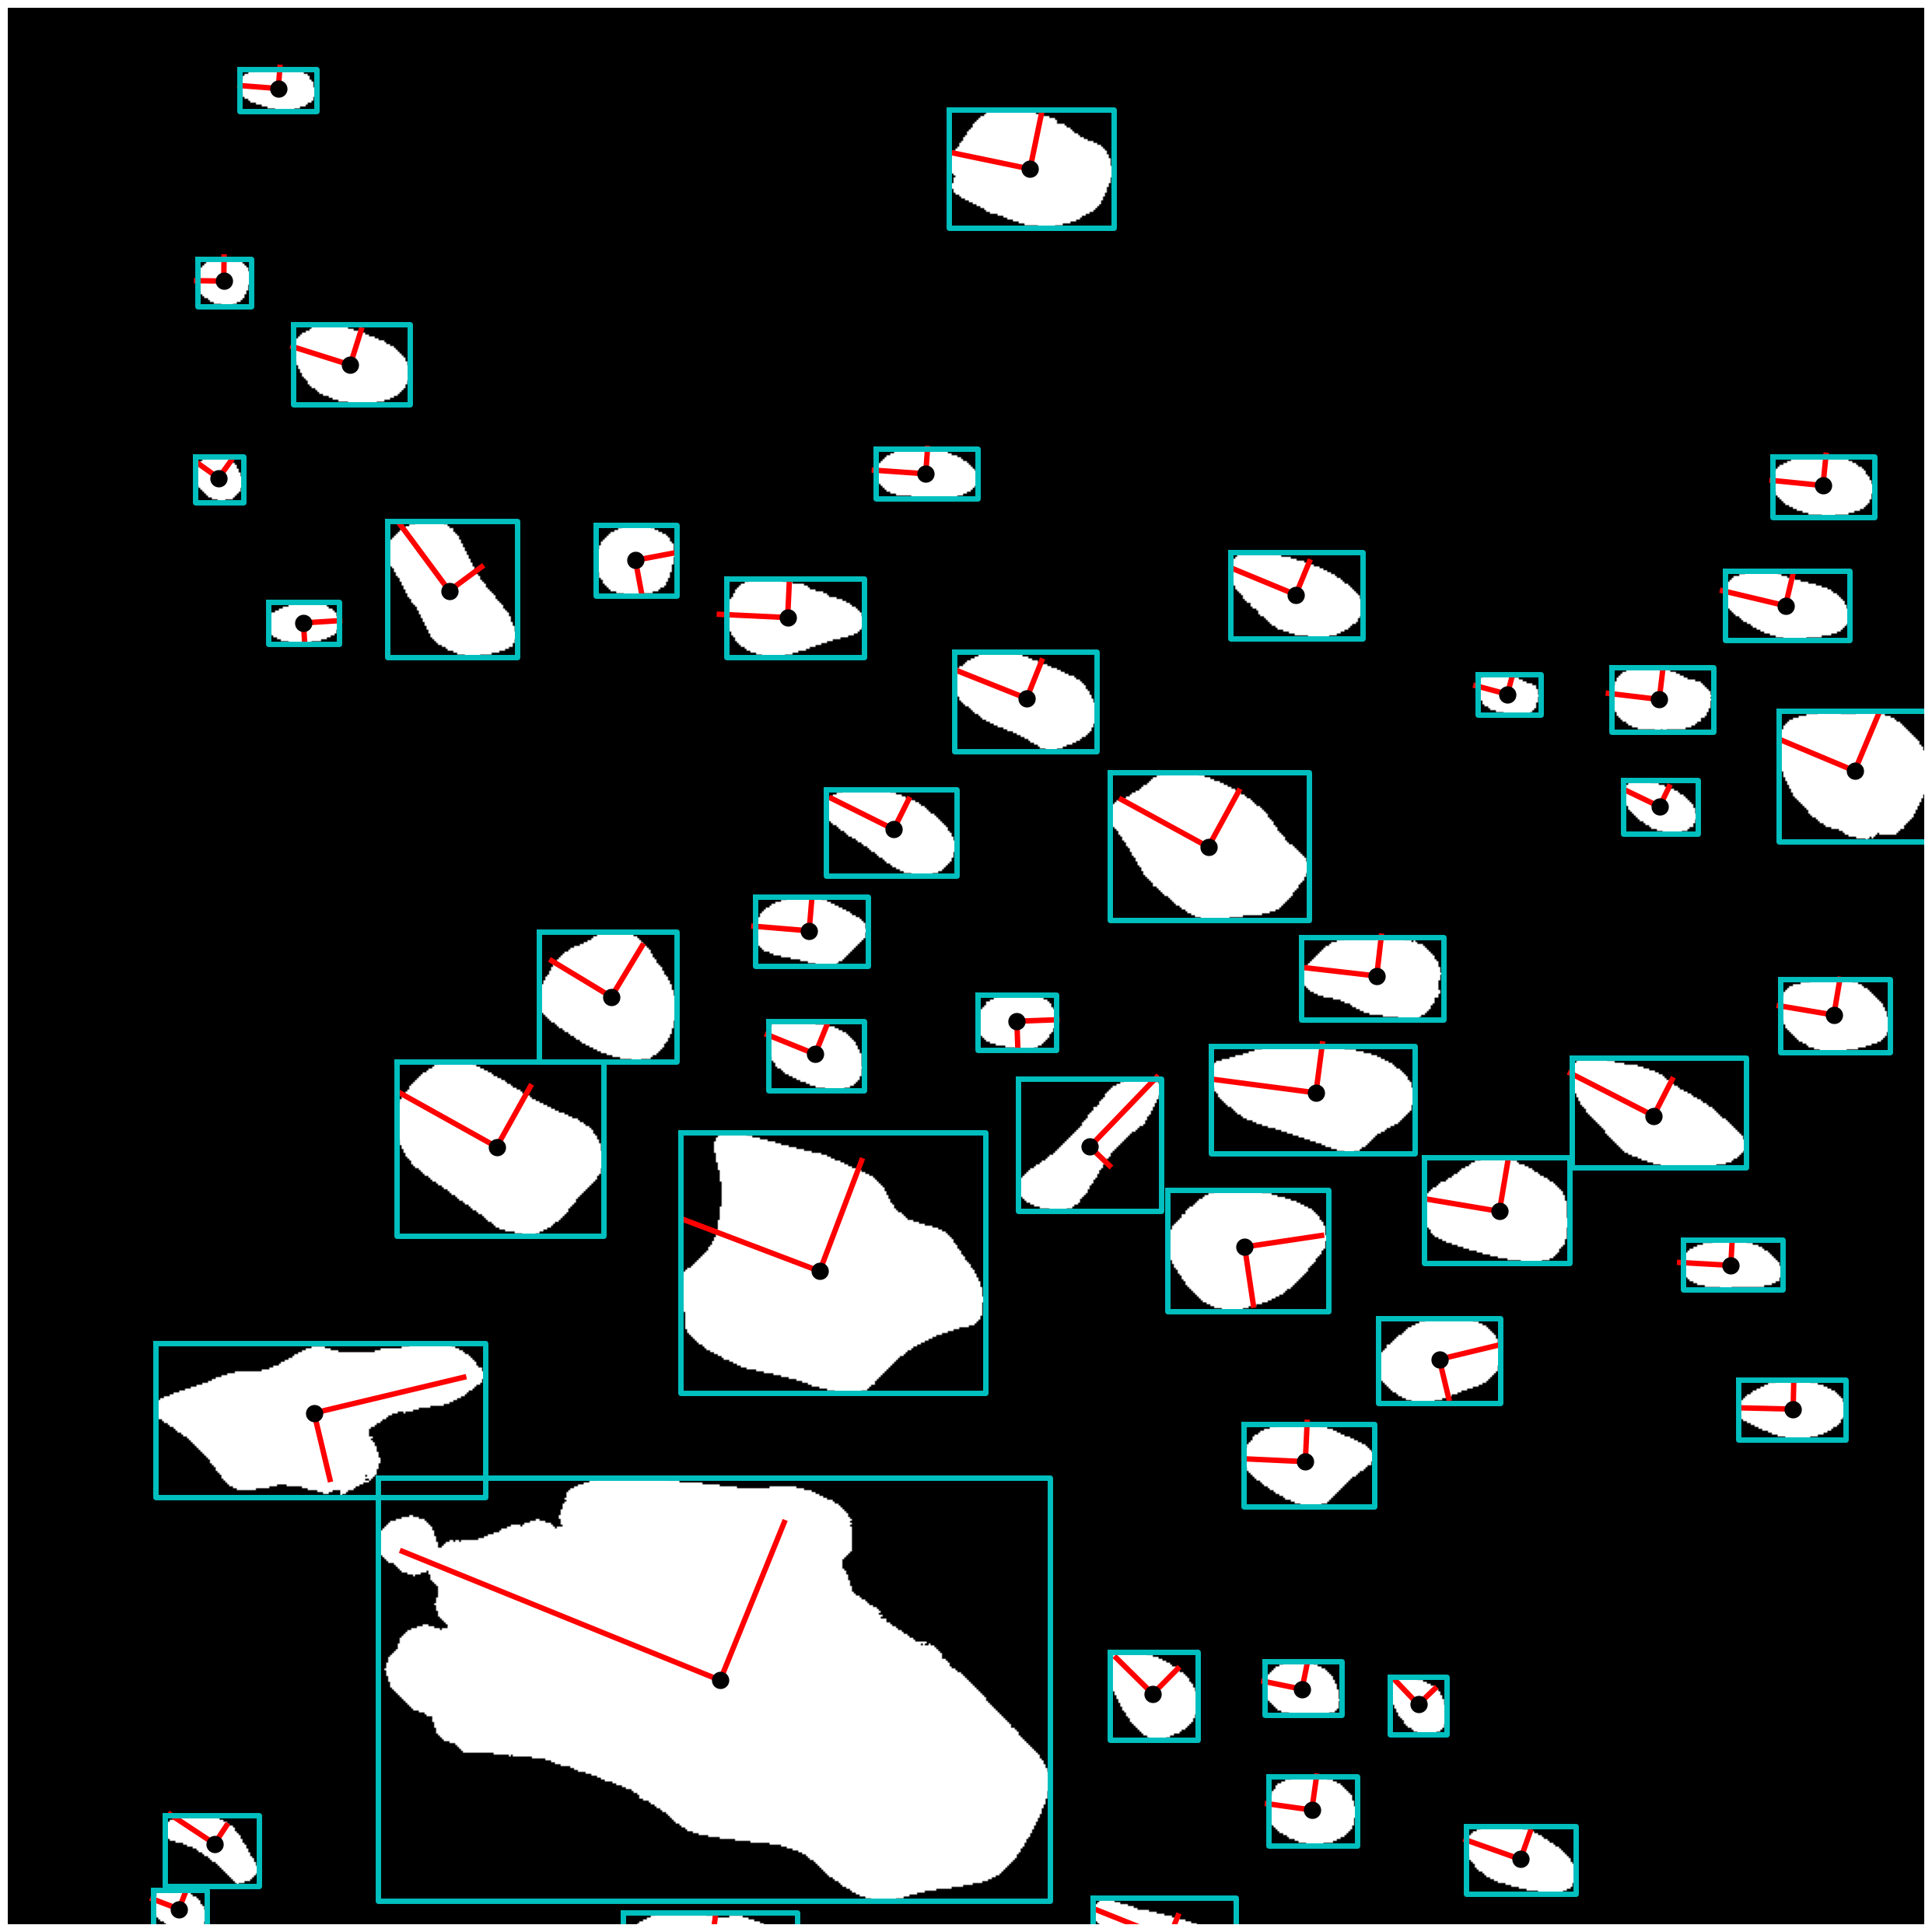

In [35]:
# plot centroids, measurements, major and minor axis on image to sanity check
regions = regionprops(pred_inner_labeled)

fig, ax = plt.subplots(figsize=(32,32))
ax.imshow(pred_inner_labeled.astype('bool'), cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + m.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - m.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - m.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - m.cos(orientation) * 0.5 * props.axis_major_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=5)
    ax.plot(x0, y0, '.k', markersize=30)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-c', linewidth=5)

ax.set_axis_off()
ax.axis((0, 1000, 1000, 0))
plt.savefig(save_path + "\inner_clocks.png",dpi=500)
plt.show()

C:\Users\Hoellenmaschine2\AppData\Local\Temp\ipykernel_16388\1491411587.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats_inner_pred = pd.concat([measurements_inner_pred.mean(),measurements_inner_pred.median(), measurements_inner_pred.std()], axis=1)
C:\Users\Hoellenmaschine2\AppData\Local\Temp\ipykernel_16388\1491411587.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats_inner_val = pd.concat([measurements_inner_val.mean(),measurements_inner_val.median(), measurements_inner_val.std()], axis=1)


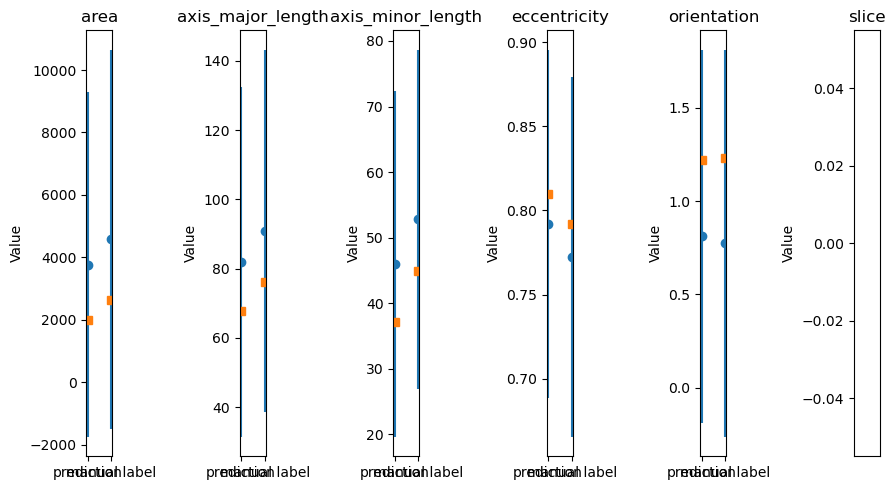

In [36]:
## now that we have the same amount of cells and all cells have the same label in both pictures, we extract measurements for validation
table_inner_pred = regionprops_table(label_image=pred_inner_labeled,
                          properties=('label',
                                      'area',
                                      'centroid',
                                      'axis_major_length',
                                      'axis_minor_length',
                                      'eccentricity',
                                      'extent',
                                      'equivalent_diameter_area',
                                      'orientation',
                                      'slice',))
measurements_inner_pred = pd.DataFrame(table_inner_pred)
#measurements_inner_pred.drop(index=66,inplace=True)

table_inner_val = regionprops_table(label_image=val_inner_labeled,
                              properties=('label',
                                          'area',
                                          'centroid',
                                          'axis_major_length',
                                          'axis_minor_length',
                                          'eccentricity',
                                          'extent',
                                          'equivalent_diameter_area',
                                          'orientation',
                                          'slice',))
measurements_inner_val = pd.DataFrame(table_inner_val)
#measurements_inner_val.drop(index=66,inplace=True)

# drop uninteresting columns for now
measurements_inner_val=measurements_inner_val.drop(columns=['label','centroid-0','centroid-1','extent','equivalent_diameter_area'])
measurements_inner_pred=measurements_inner_pred.drop(columns=['label','centroid-0','centroid-1','extent','equivalent_diameter_area'])

# calculate mean and std of all columns for both dataframes
stats_inner_pred = pd.concat([measurements_inner_pred.mean(),measurements_inner_pred.median(), measurements_inner_pred.std()], axis=1)
stats_inner_pred.columns = ['mean','median', 'std']
stats_inner_pred['dataset'] = 'prediction'

stats_inner_val = pd.concat([measurements_inner_val.mean(),measurements_inner_val.median(), measurements_inner_val.std()], axis=1)
stats_inner_val.columns = ['mean','median', 'std']
stats_inner_val['dataset'] = 'manual label'

# combine the two datasets
stats = pd.concat([stats_inner_pred, stats_inner_val])

# plot the data as a box plot
fig, axs = plt.subplots(ncols=measurements_inner_pred.shape[1], figsize=(9, 5),)

for i, col in enumerate(measurements_inner_pred.columns):
    ax = axs[i]
    col_stats = stats.loc[stats.index == col, :]
    xticks = np.arange(len(col_stats))
    ax.errorbar(xticks, col_stats['mean'], yerr=col_stats['std'], fmt='o', label='Mean')
    ax.errorbar(xticks, col_stats['median'], fmt='s', label='Median')
    ax.set_xticks(xticks)
    ax.set_xticklabels(col_stats['dataset'])
    ax.set_title(col)
    ax.set_ylabel('Value')
    # ax.legend()
    
plt.tight_layout()
plt.savefig(save_path + "\inner_lineplot.png",dpi=500)
plt.show()

In [37]:
print('predicted stats:')
print(stats_inner_pred)
print('')
print('validation stats:')
print(stats_inner_val)

predicted stats:
                          mean       median          std     dataset
area               3769.043478  1996.000000  5522.970330  prediction
axis_major_length    81.869383    67.728935    50.505955  prediction
axis_minor_length    46.004564    37.106943    26.397070  prediction
eccentricity          0.791907     0.809812     0.103664  prediction
orientation           0.812248     1.220770     0.997657  prediction

validation stats:
                          mean       median          std       dataset
area               4577.224638  2632.500000  6074.099645  manual label
axis_major_length    90.825705    76.203651    52.404706  manual label
axis_minor_length    52.804004    44.854078    25.861596  manual label
eccentricity          0.772360     0.792181     0.106988  manual label
orientation           0.773418     1.231138     1.035836  manual label


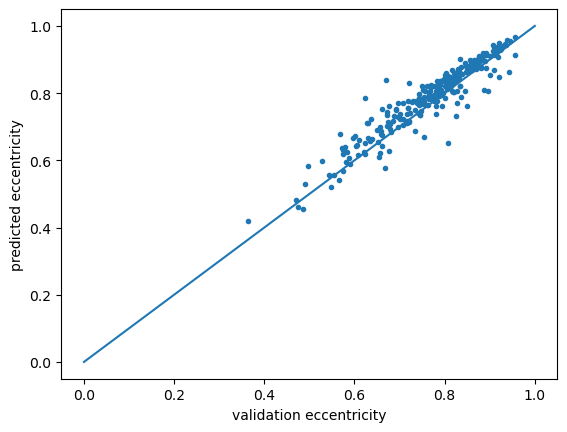

LinregressResult(slope=0.9126145691502595, intercept=0.08704032682743157, rvalue=0.9418796805678088, pvalue=8.088455511158043e-132, stderr=0.019664904577198123, intercept_stderr=0.015332878611206715)


In [38]:
x = np.arange(0,2)
y = np.arange(0,2)
set_val = (measurements_inner_val['eccentricity'])
set_pred = (measurements_inner_pred['eccentricity'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation eccentricity')
plt.ylabel('predicted eccentricity')
plt.savefig(save_path + "\inner_ecc.png",dpi=500)
plt.show()
print(stats_val_pred)

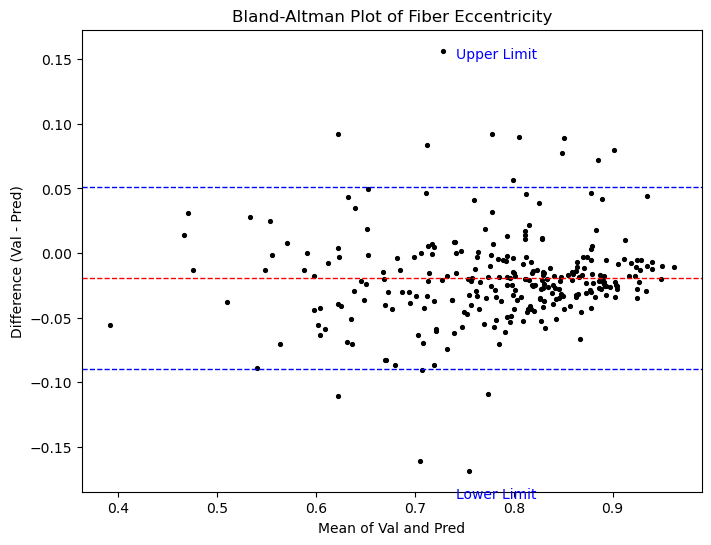

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming set_val and set_pred are numpy arrays or lists
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Fiber Eccentricity')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\inner_ecc_ba.png",dpi=500)

# Display the plot
plt.show()


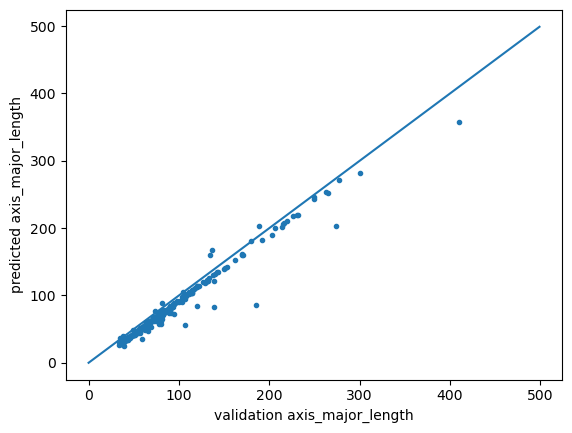

LinregressResult(slope=0.947630288596941, intercept=-4.199805612257862, rvalue=0.9832560726641645, pvalue=1.2568885209001175e-204, stderr=0.010609992486186933, intercept_stderr=1.1120573851643962)


In [40]:
x = np.arange(0,500)
y = np.arange(0,500)
set_val = (measurements_inner_val['axis_major_length'])
set_pred = (measurements_inner_pred['axis_major_length'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation axis_major_length')
plt.ylabel('predicted axis_major_length')
#plt.ylim(-20,520)
#plt.xlim(-20,520)
plt.savefig(save_path + "\inner_major.png",dpi=500)
plt.show()
print(stats_val_pred)

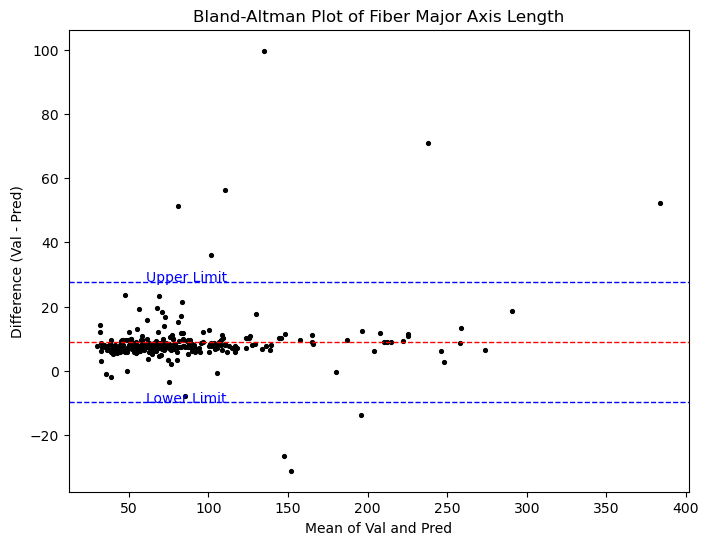

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming set_val and set_pred are numpy arrays or lists
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30,marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Fiber Major Axis Length')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Display the plot
plt.show()


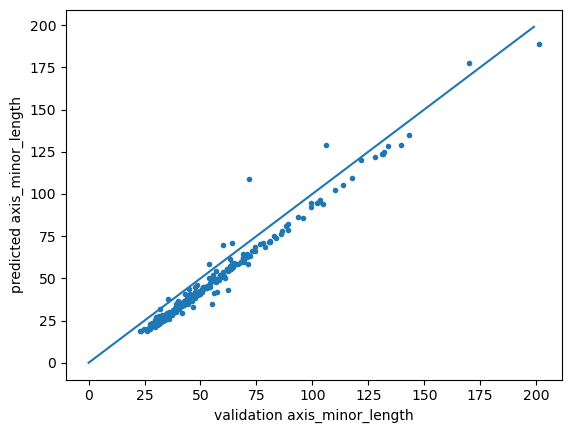

LinregressResult(slope=1.007354734008665, intercept=-7.187799413590341, rvalue=0.986920174061791, pvalue=3.26235431828574e-219, stderr=0.009940685080365599, intercept_stderr=0.5842773884093868)


In [42]:
x = np.arange(0,200)
y = np.arange(0,200)
set_val = (measurements_inner_val['axis_minor_length'])
set_pred = (measurements_inner_pred['axis_minor_length'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation axis_minor_length')
plt.ylabel('predicted axis_minor_length')
plt.savefig(save_path + "\inner_minor.png",dpi=500)
plt.show()
print(stats_val_pred)

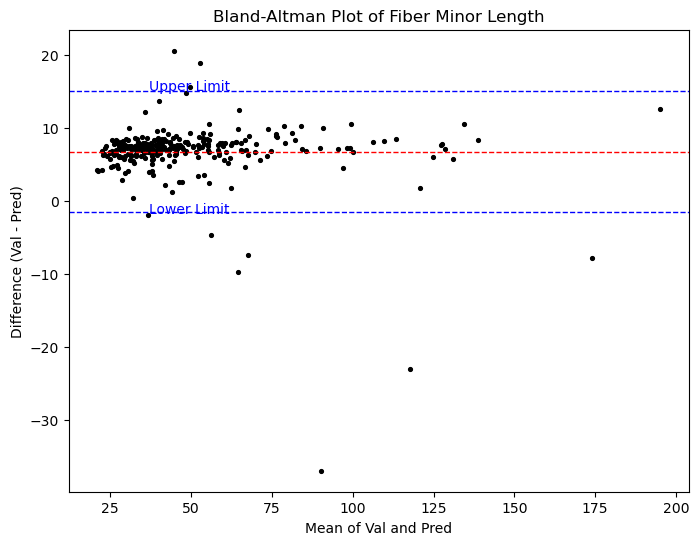

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming set_val and set_pred are numpy arrays or lists
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Fiber Minor Length')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\inner_minor_ba.png",dpi=500)

# Display the plot
plt.show()


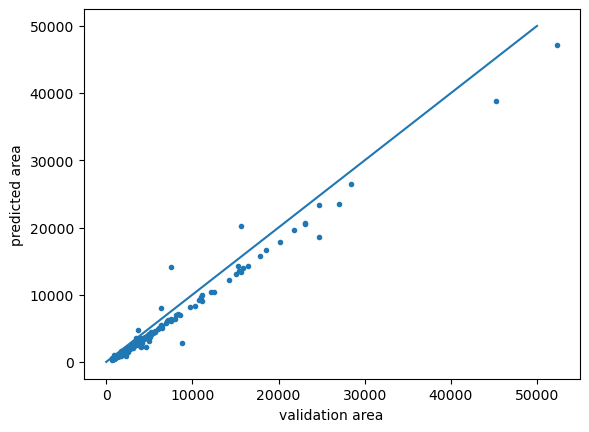

LinregressResult(slope=0.9002291725951089, intercept=-351.5076701007879, rvalue=0.9900617549757531, pvalue=1.83282593228131e-235, stderr=0.007725091698058038, intercept_stderr=58.686294513147004)


In [44]:
x = np.arange(0,50000)
y = np.arange(0,50000)
set_val = (measurements_inner_val['area'])
set_pred = (measurements_inner_pred['area'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation area')
plt.ylabel('predicted area')
plt.savefig(save_path + "\inner_area.png",dpi=500)
plt.show()
print(stats_val_pred)

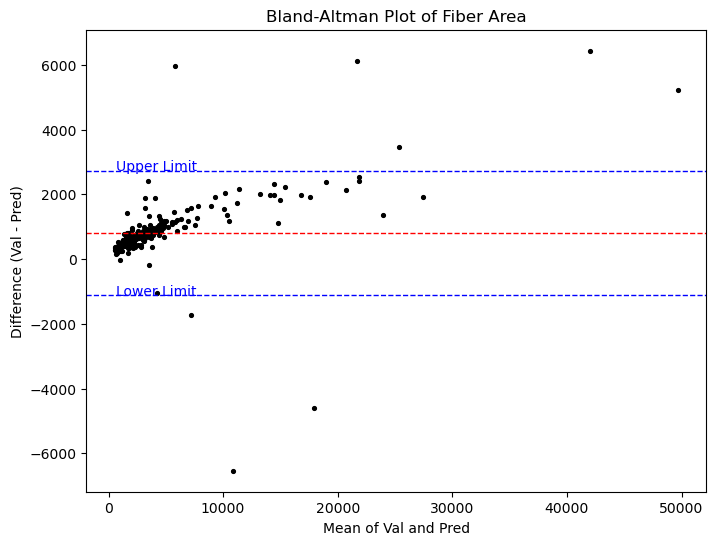

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming set_val and set_pred are numpy arrays or lists
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Fiber Area')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\inner_area_ba.png",dpi=500)

# Display the plot
plt.show()


In [46]:
# ### this code block is not final. need fo find a good solution for this problem.

# # iterate through np.unique(pred_outer_labeled), delete all cells that do not have axon or myelin.
# for id in np.unique(pred_outer_labeled):
#     # check if id is in pred_outer_labeled
#     if id not in val_outer_labeled:
#         # if not, delete in pred_inner_labeled
#         pred_outer_labeled[pred_outer_labeled==id] = 0
#         print("deleted prediction label #" + str(id))
    

# for id in np.unique(val_outer_labeled):
#     if id not in pred_outer_labeled:
#         # if not, delete in pred_outer_labeled
#         val_outer_labeled[val_outer_labeled==id] = 0
#         print("deleted validation label #" + str(id))


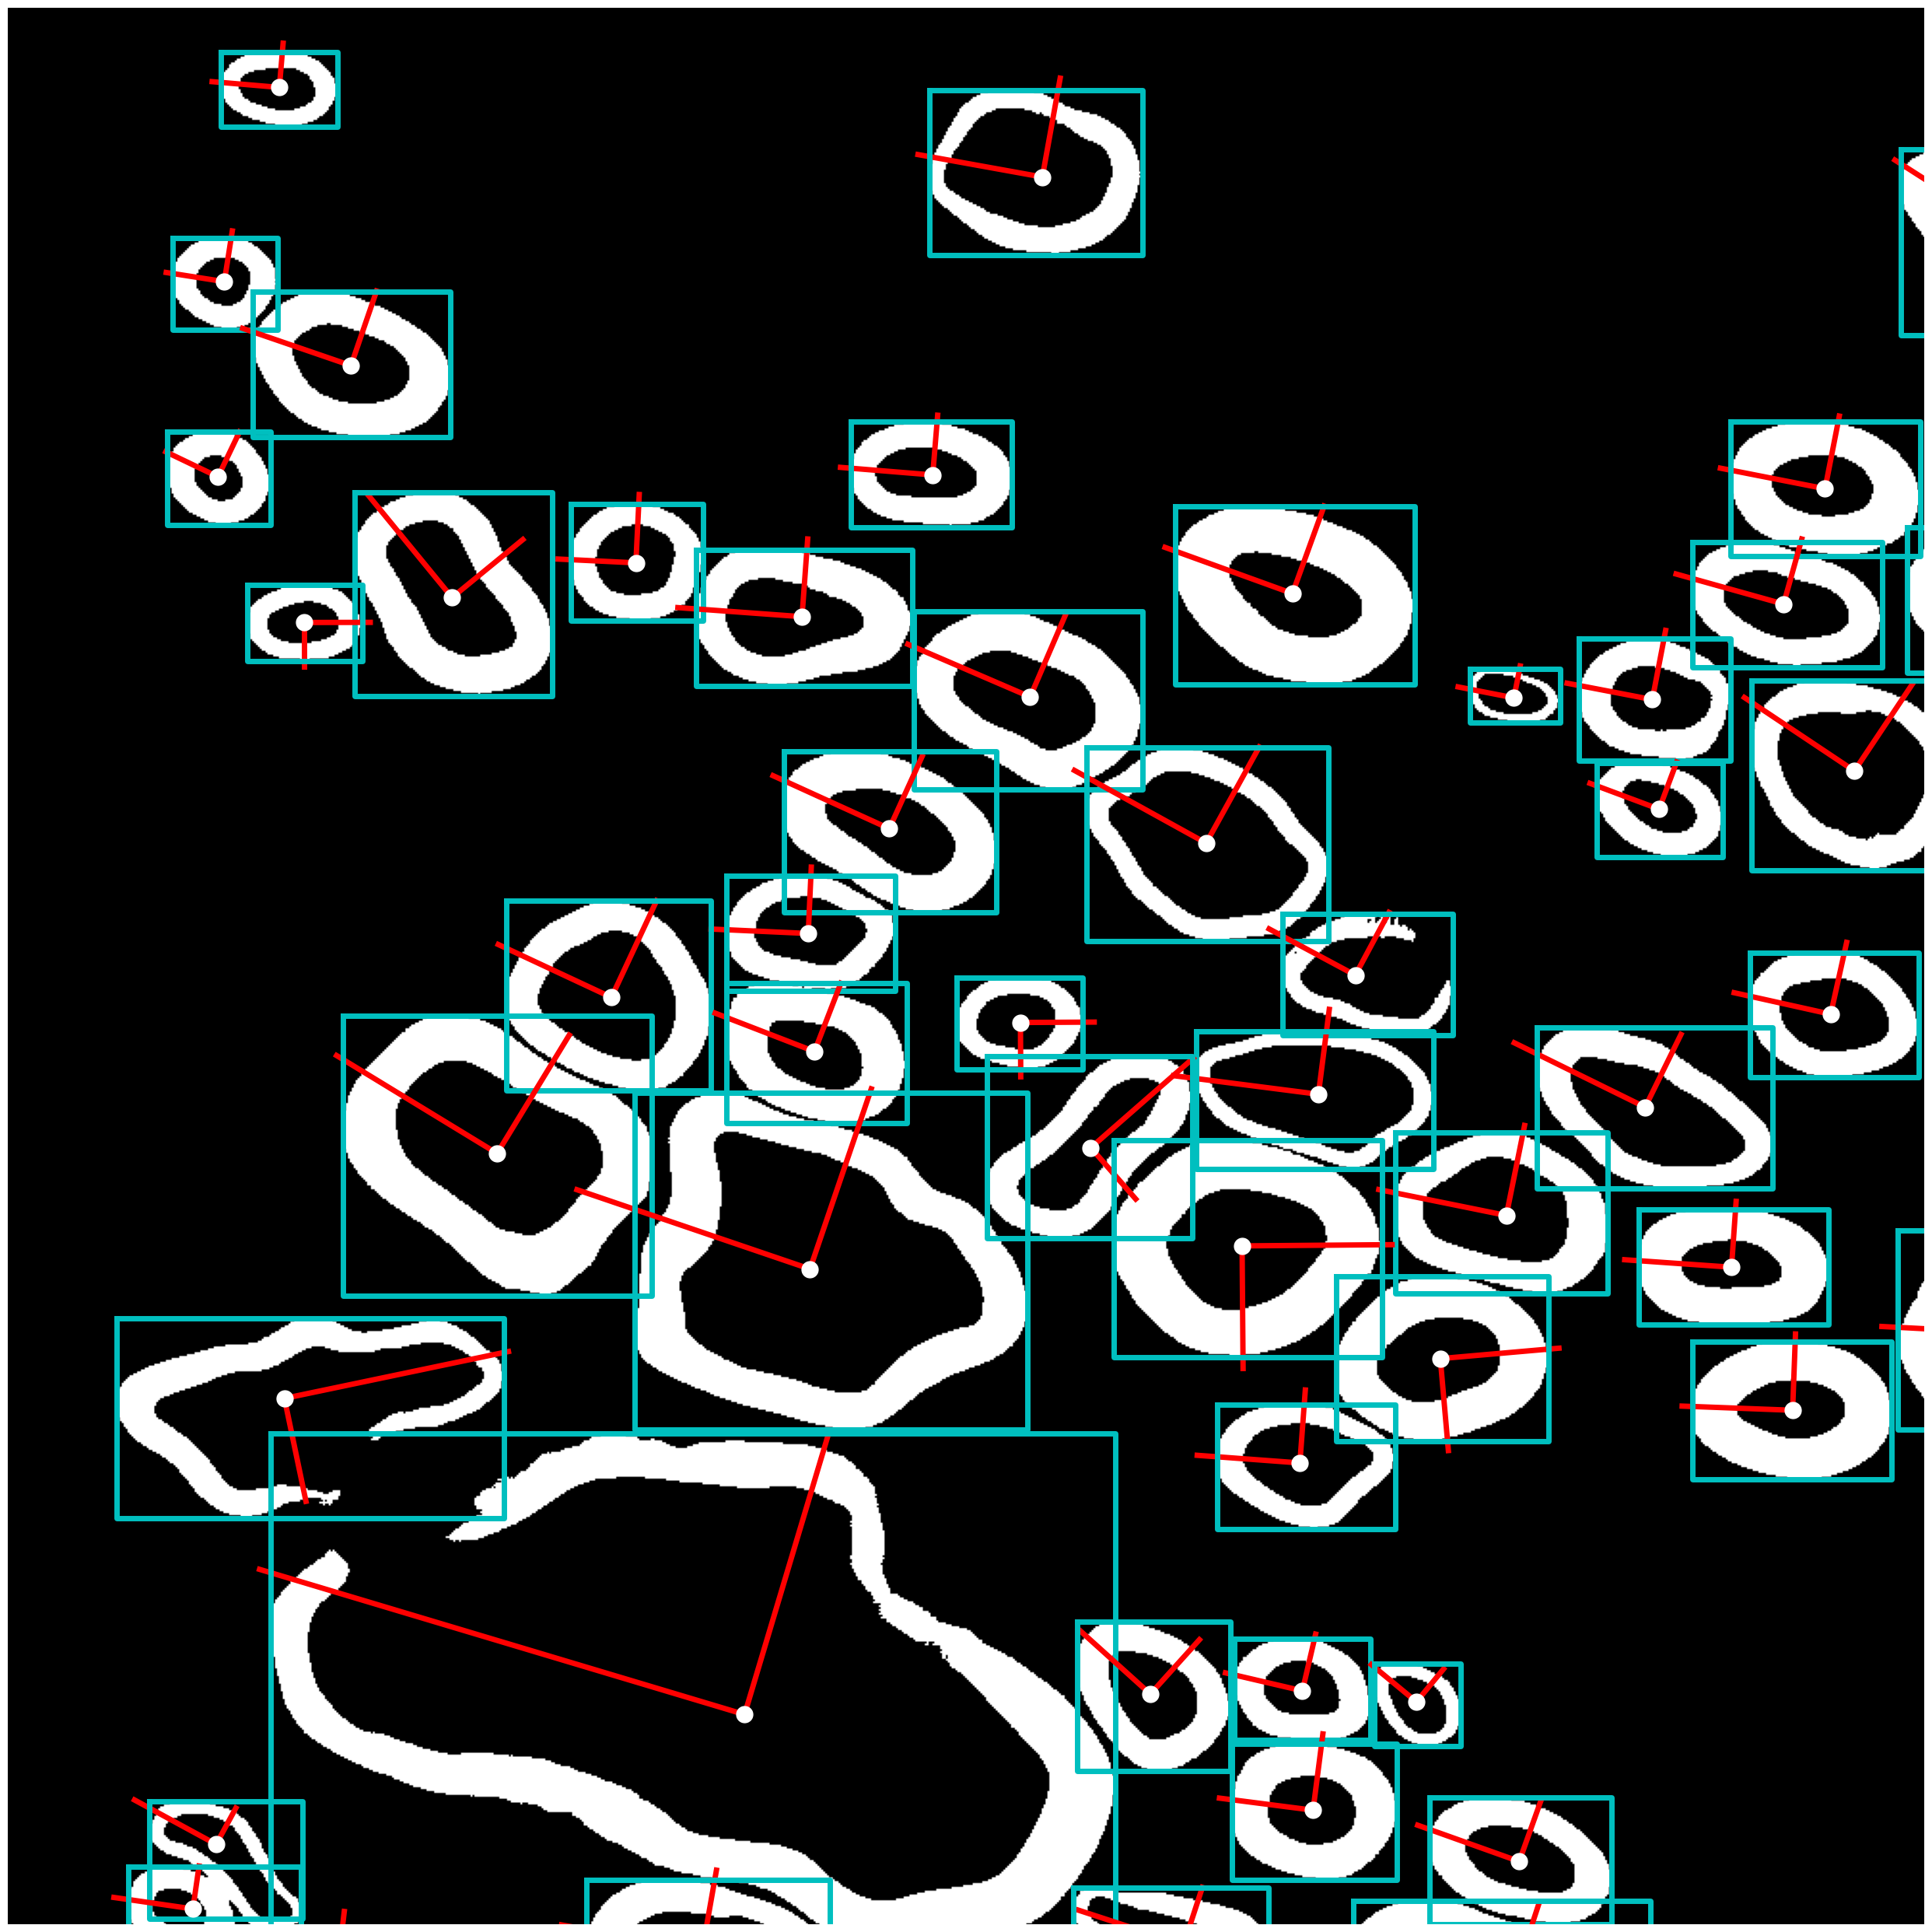

In [47]:
##### now do the same as above for the outer channel
# plot centroids, measurements, major and minor axis on image to sanity check
regions = regionprops(pred_outer_labeled)

fig, ax = plt.subplots(figsize=(32,32))
ax.imshow(pred_outer_labeled.astype('bool'), cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + m.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - m.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - m.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - m.cos(orientation) * 0.5 * props.axis_major_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=5)
    ax.plot(x0, y0, '.w', markersize=30)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-c', linewidth=5)

ax.set_axis_off()
ax.axis((0, 1000, 1000, 0))
plt.savefig(save_path + "\outer_clocks.png",dpi=500)
plt.show()

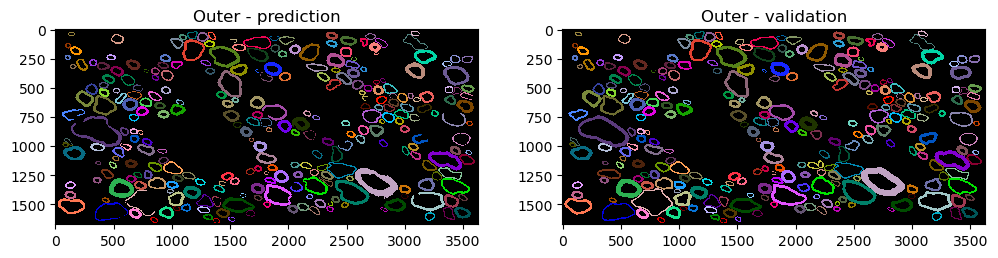

In [48]:
## do the same regression analysis as before
# visually compare outer_labeled and validation data
fig, axs = plt.subplots(ncols=2,figsize=(12,12))
axs[0].imshow(pred_outer_labeled, cmap=glasbey,interpolation='none',vmin=0.1,vmax=pred_outer_labeled.max())
axs[1].imshow(val_outer_labeled, cmap=glasbey,interpolation='none',vmin=0.1,vmax=pred_outer_labeled.max())
axs[0].set_title('Outer - prediction')
axs[1].set_title('Outer - validation')
plt.show()

C:\Users\Hoellenmaschine2\AppData\Local\Temp\ipykernel_16388\3222987075.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats_outer_pred = pd.concat([measurements_outer_pred.mean(),measurements_outer_pred.median(), measurements_outer_pred.std()], axis=1)
C:\Users\Hoellenmaschine2\AppData\Local\Temp\ipykernel_16388\3222987075.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats_outer_val = pd.concat([measurements_outer_val.mean(),measurements_outer_val.median(), measurements_outer_val.std()], axis=1)


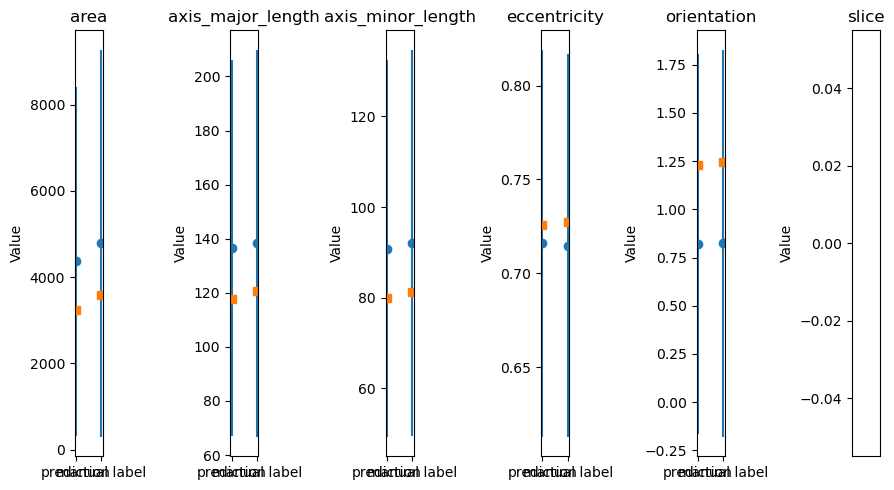

In [49]:
## now that we have the same amount of cells and all cells have the same label in both pictures, we extract measurements for validation
table_outer_pred = regionprops_table(label_image=pred_outer_labeled,
                          properties=('label',
                                      'area',
                                      'centroid',
                                      'axis_major_length',
                                      'axis_minor_length',
                                      'eccentricity',
                                      'extent',
                                      'equivalent_diameter_area',
                                      'orientation',
                                      'slice'))
measurements_outer_pred = pd.DataFrame(table_outer_pred)
#measurements_outer_pred.drop(66,inplace=True)

table_outer_val = regionprops_table(label_image=val_outer_labeled,
                              properties=('label',
                                          'area',
                                          'centroid',
                                          'axis_major_length',
                                          'axis_minor_length',
                                          'eccentricity',
                                          'extent',
                                          'equivalent_diameter_area',
                                          'orientation',
                                          'slice'))
measurements_outer_val = pd.DataFrame(table_outer_val)
#measurements_outer_val.drop(66,inplace=True)

# drop uninteresting columns for now
measurements_outer_val=measurements_outer_val.drop(columns=['label','centroid-0','centroid-1','extent','equivalent_diameter_area'])
measurements_outer_pred=measurements_outer_pred.drop(columns=['label','centroid-0','centroid-1','extent','equivalent_diameter_area'])

# calculate mean and std of all columns for both dataframes
stats_outer_pred = pd.concat([measurements_outer_pred.mean(),measurements_outer_pred.median(), measurements_outer_pred.std()], axis=1)
stats_outer_pred.columns = ['mean','median', 'std']
stats_outer_pred['dataset'] = 'prediction'

stats_outer_val = pd.concat([measurements_outer_val.mean(),measurements_outer_val.median(), measurements_outer_val.std()], axis=1)
stats_outer_val.columns = ['mean','median', 'std']
stats_outer_val['dataset'] = 'manual label'

# combine the two datasets
stats = pd.concat([stats_outer_pred, stats_outer_val])

# plot the data as a box plot
fig, axs = plt.subplots(ncols=measurements_outer_pred.shape[1], figsize=(9, 5),)

for i, col in enumerate(measurements_outer_pred.columns):
    ax = axs[i]
    col_stats = stats.loc[stats.index == col, :]
    xticks = np.arange(len(col_stats))
    ax.errorbar(xticks, col_stats['mean'], yerr=col_stats['std'], fmt='o', label='Mean')
    ax.errorbar(xticks, col_stats['median'], fmt='s', label='Median')
    ax.set_xticks(xticks)
    ax.set_xticklabels(col_stats['dataset'])
    ax.set_title(col)
    ax.set_ylabel('Value')

# ax.legend(bbox_to_anchor=(2.5,0.5))
plt.tight_layout()
plt.savefig(save_path + "\outer_lineplot.png",dpi=500)
plt.show()

In [50]:
print('predicted stats:')
print(stats_outer_pred)
print('')
print('validation stats:')
print(stats_outer_val)

predicted stats:
                          mean       median          std     dataset
area               4372.148551  3241.500000  4046.115094  prediction
axis_major_length   136.596927   117.786044    69.634291  prediction
axis_minor_length    90.800161    79.886168    41.554222  prediction
eccentricity          0.716053     0.725537     0.103106  prediction
orientation           0.821863     1.231217     0.984696  prediction

validation stats:
                          mean       median          std       dataset
area               4784.952899  3598.000000  4487.544312  manual label
axis_major_length   138.296088   120.759288    71.582640  manual label
axis_minor_length    92.093604    81.177152    42.643270  manual label
eccentricity          0.714731     0.727602     0.101924  manual label
orientation           0.823866     1.242999     1.003905  manual label


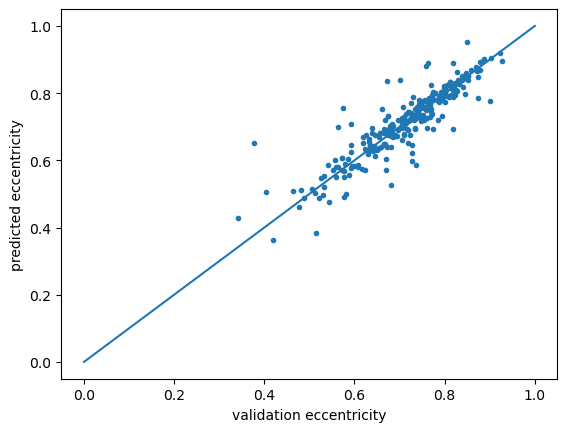

LinregressResult(slope=0.9111990430098507, intercept=0.06479118398178285, rvalue=0.9007550940121688, pvalue=3.087506189399838e-101, stderr=0.026542904259036902, intercept_stderr=0.019162272675359488)


In [51]:
x = np.arange(0,2)
y = np.arange(0,2)
set_val = (measurements_outer_val['eccentricity'])
set_pred = (measurements_outer_pred['eccentricity'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation eccentricity')
plt.ylabel('predicted eccentricity')
plt.savefig(save_path + "\outer_ecc.png",dpi=500)
plt.show()
print(stats_val_pred)

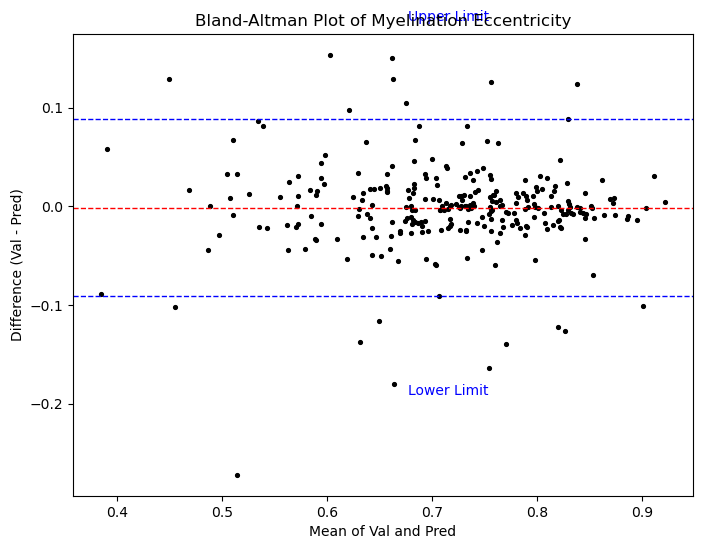

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming set_val and set_pred are numpy arrays or lists
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Myelination Eccentricity')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\outer_ecc_ba.png",dpi=500)

# Display the plot
plt.show()


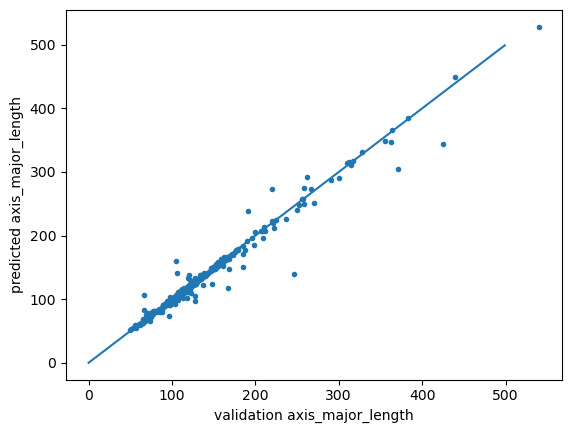

LinregressResult(slope=0.9566490714607634, intercept=4.296102220192751, rvalue=0.9834158612877111, pvalue=3.4158296360645523e-205, stderr=0.010658436840936557, intercept_stderr=1.659136145892662)


In [53]:
x = np.arange(0,500)
y = np.arange(0,500)
set_val = (measurements_outer_val['axis_major_length'])
set_pred = (measurements_outer_pred['axis_major_length'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation axis_major_length')
plt.ylabel('predicted axis_major_length')
plt.savefig(save_path + "\outer_major.png",dpi=500)
plt.show()
print(stats_val_pred)

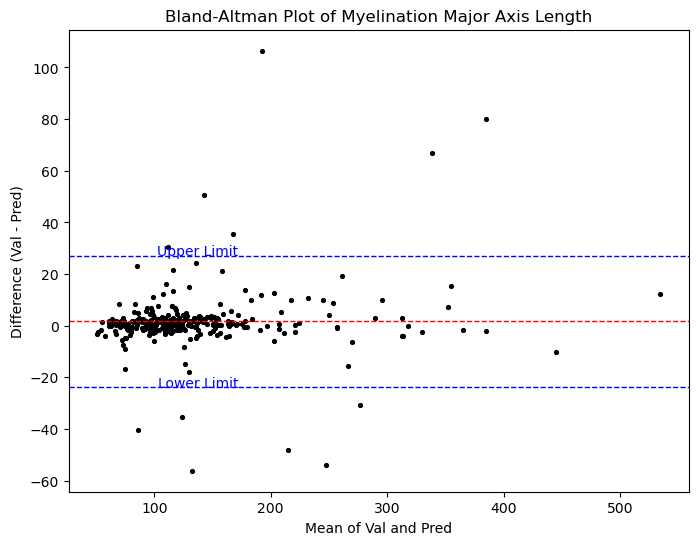

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming set_val and set_pred are numpy arrays or lists
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Myelination Major Axis Length')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\outer_major_ba.png",dpi=500)

# Display the plot
plt.show()


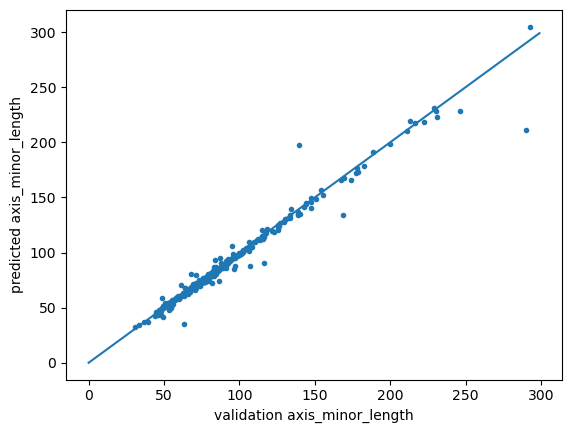

LinregressResult(slope=0.959594462925807, intercept=2.4276491996243124, rvalue=0.9847434132114243, pvalue=4.059350135223397e-210, stderr=0.010244015902023167, intercept_stderr=1.0393053585472292)


In [55]:
x = np.arange(0,300)
y = np.arange(0,300)
set_val = (measurements_outer_val['axis_minor_length'])
set_pred = (measurements_outer_pred['axis_minor_length'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation axis_minor_length')
plt.ylabel('predicted axis_minor_length')
plt.savefig(save_path + "\outer_minor.png",dpi=500)
plt.show()
print(stats_val_pred)

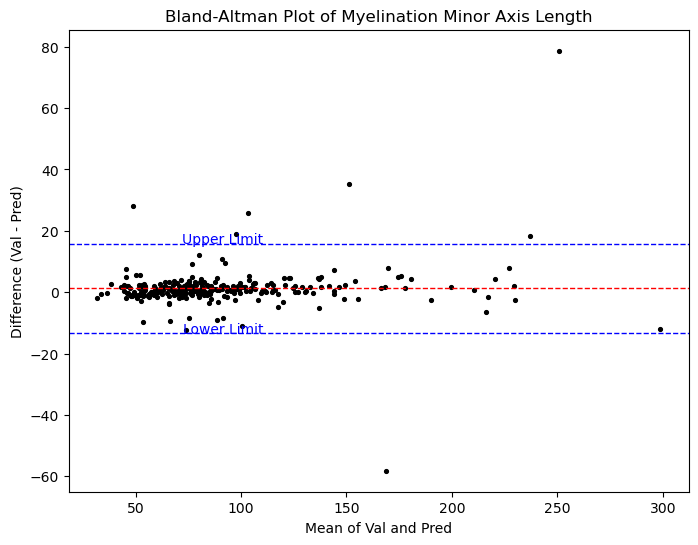

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming set_val and set_pred are numpy arrays or lists
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Myelination Minor Axis Length')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\outer_minor_ba.png",dpi=500)

# Display the plot
plt.show()


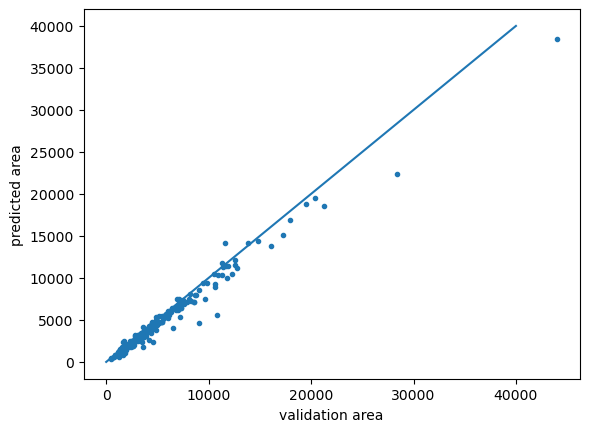

LinregressResult(slope=0.890900840235269, intercept=109.2299929196106, rvalue=0.9880976949113646, pvalue=8.615016466770088e-225, stderr=0.008378930747731333, intercept_stderr=54.91931423135623)


In [57]:
x = np.arange(0,40000)
y = np.arange(0,40000)
set_val = (measurements_outer_val['area'])
set_pred = (measurements_outer_pred['area'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation area')
plt.ylabel('predicted area')
plt.savefig(save_path + "\outer_area.png",dpi=500)
plt.show()
print(stats_val_pred)

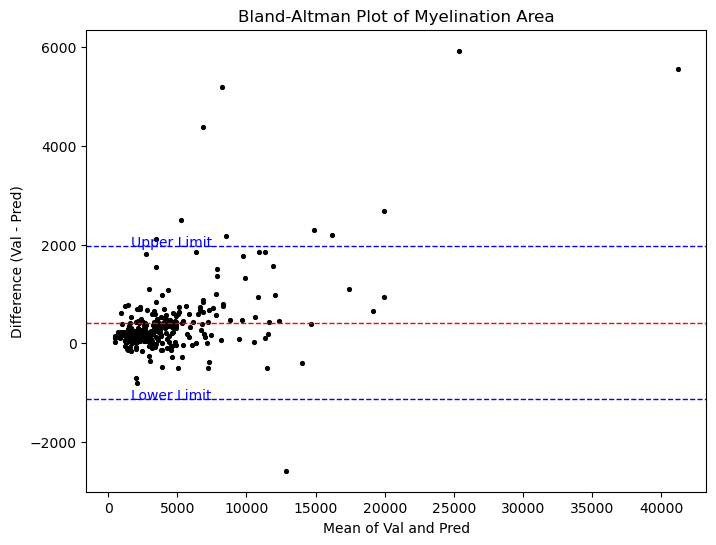

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming set_val and set_pred are numpy arrays or lists
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Myelination Area')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\outer_area_ba.png",dpi=500)

# Display the plot
plt.show()


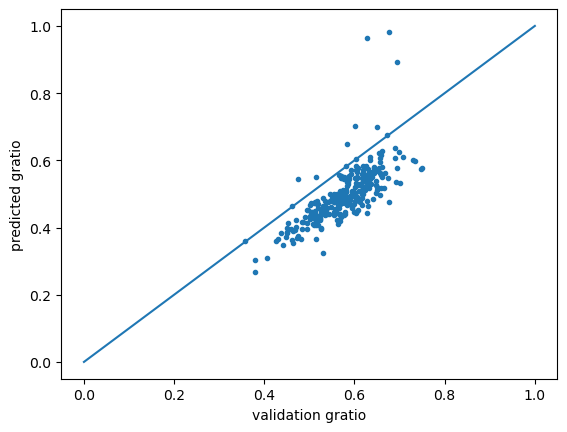

LinregressResult(slope=0.9197411152872169, intercept=-0.03330777476694524, rvalue=0.7342411879526417, pvalue=5.34942441922373e-48, stderr=0.05137480209753052, intercept_stderr=0.02976253890835135)


In [59]:
# calculate gratio for validation and prediction set, plot them against each other and run linreg
# gratio = inner_minor/outer_minor
x = np.arange(0,2)
y = np.arange(0,2)

gratio_pred = measurements_inner_pred['axis_minor_length']/measurements_outer_pred['axis_minor_length']
gratio_val  = measurements_inner_val['axis_minor_length']/measurements_outer_val['axis_minor_length']

stats_val_pred = scipy.stats.linregress(gratio_val,gratio_pred)

plt.scatter(gratio_val,gratio_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation gratio')
plt.ylabel('predicted gratio')
plt.savefig(save_path + "\gratio.png",dpi=500)
plt.show()
print(stats_val_pred)

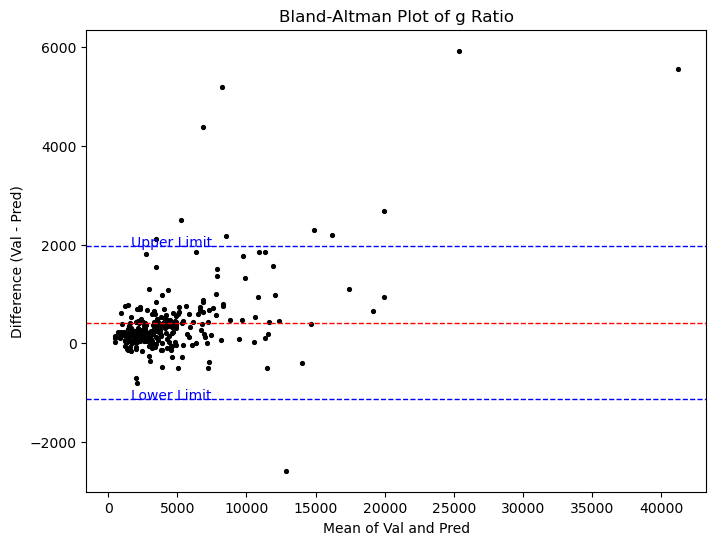

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming set_val and set_pred are numpy arrays or lists
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of g Ratio')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\gratio_ba.png",dpi=500)

# Display the plot
plt.show()


In [61]:
# print other statistics
print ("Correctly identified cells (prediction): " + str (len(set_pred)))
print ("False Positives (prediction): " + str (n_false_positive))
print ("False Negatives (prediction): " + str (n_false_negative))
print ("Percentage of cells found: " + str(len(set_pred)/(len(set_pred)+n_false_negative))) # found cells divided by found cells + false negatives
print ("Percentage of cells falsely identified: " + str(n_false_positive/(len(set_pred)+n_false_positive)))
print ("Cells removed because of touching border (prediction): " + str(n_cells_removed_border_pred))
print ("Cells removed because of touching border (validation): " + str(n_cells_removed_border_val))
print ("Cells removed because labeled without inner (prediction): " + str (n_labeled_without_inner))
print ("Cells removed because labeled without outer (prediction): " + str (n_labeled_without_outer))

Correctly identified cells (prediction): 276
False Positives (prediction): 47
False Negatives (prediction): 36
Percentage of cells found: 0.8846153846153846
Percentage of cells falsely identified: 0.14551083591331268
Cells removed because of touching border (prediction): 43
Cells removed because of touching border (validation): 8
Cells removed because labeled without inner (prediction): 0
Cells removed because labeled without outer (prediction): 72


In [62]:
len(set_pred)

276

##### code graveyard
Code not needed at the moment. Resurrect if needed.

In [63]:

# # define which cell belongs to which other cell
# centroids_val = regionprops_table(label_image=mask_val_labeled,properties=('centroid',))
# centroids_val_x = centroids_val['centroid-0']
# centroids_val_y = centroids_val['centroid-1']

# centroids_pred = regionprops_table(label_image=mask_labeled,properties=('centroid',))
# centroids_pred_x = centroids_pred['centroid-0']
# centroids_pred_y = centroids_pred['centroid-1']

# # stack arrays to 2-dimensional arrays
# val_points = np.column_stack((centroids_val_x, centroids_val_y))
# pred_points = np.column_stack((centroids_pred_x, centroids_pred_y))

# # find nearest neighbours in prediction centroids to validation centroids using KDTree
# tree = KDTree(val_points)
# distances, indices = tree.query(pred_points)
# nearest_points = val_points[indices]

# # initialize bool_array which has True values where nearest points are
# bool_array = np.zeros_like(mask_labeled, dtype=bool)
# for yx in nearest_points:
#     bool_array[round(yx[0]),round(yx[1])]=True

# for id in np.unique(mask_labeled):
#     #keep only current cell as temporary mask
#     current_id_mask = mask_labeled==id 

#     # check if it overlaps with any nearest point
#     overlap = np.logical_and(bool_array,current_id_mask)
#     overlap_n = np.sum(overlap)

#     if overlap_n < 1: # if there is no overlap with any nearest_point: delete cell
#         mask_labeled[mask_labeled==id] = 0

# mask_labeled,n_mask_labeled = ndi.label(mask_labeled.astype('bool'))
# print(n_mask_labeled)

In [64]:
# #final relabeling according to np.logical_and of pred_inner_labeled and val_inner_labeled.
# bool_congruence = np.logical_and(pred_inner_labeled,val_inner_labeled)

# bool_congruence_labeled, n_cong = ndi.label(bool_congruence)

# # Here, we start to define which cell belongs to which other cell. 
# # Start by extracting centroids from the validation and prediction data.
# centroids_cong = regionprops_table(label_image=bool_congruence_labeled,properties=('centroid',))
# centroids_cong_x = centroids_cong['centroid-0']
# centroids_cong_y = centroids_cong['centroid-1']

# # stack arrays to 2-dimensional arrays
# cong_points = np.column_stack((centroids_val_x, centroids_val_y))

# # initialize boolean array which has True values where centroids are
# cong_bool_array = np.zeros_like(pred_both_labeled, dtype=bool)
# for yx in cong_points:
#     cong_bool_array[round(yx[0]),round(yx[1])]=True

# # label centroid bool arrays for iterating through them
# bool_array_cong_labeled,n_cong = ndi.label(cong_bool_array)

# # # iterate through congruent cells, delete ones that do not have a matching predicted or validation cell
# # for id in np.unique(bool_array_cong_labeled):
# #     if id == 0:
# #         continue
# #     y,x = np.argwhere(bool_array_cong_labeled==id)[0]
# #     # if this statement is true, the cell has not been found. 
# #     # therefore, we exclude it from further validation and flood fill it with 0's in validation data.
# #     if pred_inner_labeled[y,x] == 0:
# #         if val_inner_labeled[y,x] == 0:
# #             val_both_labeled = skimage.segmentation.flood_fill(val_both_labeled,
# #                                                             (y,x),
# #                                                             new_value=0,
# #                                                             )
# #             pred_both_labeled = skimage.segmentation.flood_fill(pred_both_labeled,
# #                                                             (y,x),
# #                                                             new_value=0,
# #                                                             )

# # Now, we need to label each specific cell with the same label in mask_val_labeled and mask_labeled.
# # To do that, we iterate through the prediction array and label the validation cells with the same number.
# # We do this by flood filling from each centroid.

# for id in np.unique(bool_array_cong_labeled):
#     if id == 0:
#         continue
    
#     y,x = np.argwhere(bool_array_cong_labeled==id)[0]

#     # if there is no cell at the point want to fill it in, delete cell altogether
#     if pred_both_labeled[y,x]==0: # if this is true: delete cell
#         val_both_labeled = skimage.segmentation.flood_fill(image=val_both_labeled,
#                                                            seed_point=(y,x),
#                                                            new_value=0,
#                                                           )
#         continue

#     # if there is a cell, fill it in with the same label as in mask_val_labeled
#     pred_both_labeled = skimage.segmentation.flood_fill(image=pred_both_labeled,
#                                                    seed_point=(y,x),
#                                                    new_value=id,
#                                                    )
#     # if there is a cell, fill it in with the same label as in mask_val_labeled
#     val_both_labeled = skimage.segmentation.flood_fill(image=val_both_labeled,
#                                                    seed_point=(y,x),
#                                                    new_value=id,
#                                                    )

